In [19]:
#%matplotlib notebook
import os
from datetime import datetime
from pathlib import Path
import math
import time
import numpy as np
import pandas as pd
from tabulate import tabulate
from matplotlib import pyplot as plt
import functools
import json

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

#import random
#import matplotlib.pyplot as plt
#import sklearn
#from pandas import read_csv
#from pandas import DataFrame
#from pandas import concat
#from datetime import datetime
#import datetime

#import torch
#import torch.nn as nn
#import torch.optim as optim
#from torch.utils.data import Dataset, DataLoader

import importlib
import plt_utils as pu
import evaluator as ev
import SMOTER as smtr
import forecasting_models as fmod
import relevance as rlv
import prepare_data as dprep
import GAN as gmod

#allows update import custom modules without having to restart kernel:
importlib.reload(pu)
importlib.reload(ev)
importlib.reload(smtr)
importlib.reload(fmod)
importlib.reload(rlv)
importlib.reload(dprep)
importlib.reload(gmod)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

**Importing Data**

In [20]:
def import_data(file_name, tvar=None, fvars=None):
    with open('data\\meta.json','r') as file:
        meta = json.load(file)
    meta = meta[file_name]
    ds_name = meta['name']
    if file_name == 'london_merged.csv':
        #this dataset is multi-variate, can call this function with specified targets/features or just use defaults
        if not tvar: tvar = meta['tv']
        if not fvars: fvars = [tvar]
        df=pd.read_csv(f"data\\{file_name}")
        df=df.reset_index()[fvars if tvar in fvars else [tvar] + fvars]
    else:
        #rest of the datasets are univariate and don't have headers
        tvar = meta['tv']
        fvars = [tvar]
        df=pd.read_csv(f"data\\{file_name}", header=None, names=[tvar])
    return df, tvar, fvars, ds_name

#importing london_merged

DATA_FILE = 'london_merged.csv'
TVAR = 'Bike Share Count' 
FVARS = [TVAR]
df1, TVAR, FVARS, DATA_NAME = import_data(DATA_FILE, TVAR, FVARS)

#DATA_FILE = 'sunspot.dat'
#df1, TVAR, FVARS, DATA_NAME = import_data(DATA_FILE)

#Note: Since we've opted not to used pandas Df to store multi-var data, FVARS[1:] should always remain as the ordering of multi feature variables in the numpy array
N_FVARS = len(FVARS)
print(df1)

       Bike Share Count
0                   182
1                   138
2                   134
3                    72
4                    47
...                 ...
17409              1042
17410               541
17411               337
17412               224
17413               139

[17414 rows x 1 columns]


In [21]:
import recorder as rec
importlib.reload(rec)
to_save = {'forecast_models': False,
           'forecast_results': False,
           'resample_models': False, #best GANs 
           'resample_results': False,
           'eval_results': False, #evaluation metrics
           'logs': False,
           'figures': False,
           'parameters': False,
          }

RECORDER = rec.ExperimentRecorder(to_save, "Bike")
#LOADER = rec.ExperimentLoader(to_load, "Bike")
#load results from a previous session to compare with results from this session
#base_results_dir must contain resampling results and eval results to combine results
COMBINE_RESULTS_DIR = None #"Sessions/Bike/2023-October-13 13-41-03-532984"

#set GAN_DIR to none to train a new GAN, else give it a folder path to load from
GAN_CNN_DIR = None
GAN_FNN_DIR = None
#GAN_FNN_DIR = Path("C:\\Users\\jonny\\Documents\\RA\\EVF\\code\\thesis\\resampling\\Session Data\\2023-September-28 09-51-03-210656\\resample_models")

#set FORECAST_DIR to none to train a new LSTM, else give it a folder path to load from
FORECAST_DIR = None
#FORECAST_DIR = Path("C:\\Users\\jonny\\Documents\\RA\\EVF\\code\\thesis\\resampling\\Session Data\\2023-September-28 09-51-03-210656\\forecast_models")
loadedModels = {"loadedModels": {"GanCnnDir": GAN_CNN_DIR, "GanFnnDir":GAN_FNN_DIR, "ForecastDir": FORECAST_DIR}}
RECORDER.save_param_dict(loadedModels)

**Prepare Data for Resampling/Training**
* Split dataset into train and test split
* Convert data into Taken embedded time series format

In [22]:
RECORDER.log_print(f"Using data from: {DATA_FILE}")
RECORDER.log_print(f"Using feature variables: {FVARS} to predict target variable: '{TVAR}'")
RECORDER.save_param_dict({"importingData":{"dataFile":DATA_FILE,"targetVar":TVAR,"featVars":FVARS}})

df1 = np.array(df1).reshape(-1,N_FVARS)

scaler=MinMaxScaler(feature_range=(0,1))
df1 = df1.reshape(-1,N_FVARS)
scaled_data = scaler.fit_transform(df1) 
print(f"scaled_data: {scaled_data.shape}")

#Prep Data
N_STEPS_IN = 5
N_STEPS_OUT = 2
SPLIT_RATIO = 0.7
SAMPLE_DIM = N_STEPS_IN*N_FVARS + N_STEPS_OUT

k_X, X_train, Y_train, X_test, Y_test = dprep.split_data(scaled_data, N_STEPS_IN, N_STEPS_OUT, FVARS, N_FVARS, TVAR, SPLIT_RATIO)

RECORDER.save_param_dict({"prepData":{"nStepsIn":N_STEPS_IN,"nStepsOut":N_STEPS_OUT,"splitRatio":SPLIT_RATIO}})
RECORDER.log_print(f"Embedding steps in: {N_STEPS_IN} and steps out: {N_STEPS_OUT}")
RECORDER.log_print(f"Split dataset with training ratio: {SPLIT_RATIO}")
RECORDER.log_print(f"""Split data shapes:\n\t X_train: {X_train.shape}\n\t Y_train: {Y_train.shape}\n\t X_test: {X_test.shape}\n\t Y_test: {Y_test.shape}\n\t k_X: {k_X.shape}""")

LOG: 16:01:54:942 Using data from: london_merged.csv

LOG: 16:01:54:943 Using feature variables: ['Bike Share Count'] to predict target variable: 'Bike Share Count'

scaled_data: (17414, 1)
LOG: 16:01:54:951 Embedding steps in: 5 and steps out: 2

LOG: 16:01:54:951 Split dataset with training ratio: 0.7

LOG: 16:01:54:951 Split data shapes:
	 X_train: (12185, 5, 1)
	 Y_train: (12185, 2)
	 X_test: (5223, 5, 1)
	 Y_test: (5223, 2)
	 k_X: (12185, 7)



**Relevance**

In [23]:
#give this guy a list of training target values and it will give you a function that you can input target values to get a relevance score
def getPoisRelFunc(y):
    sample_mean = np.mean(y) 
    sample_std = np.std(y)
    rel_quant = np.quantile(1/rlv.dpois(y,sample_mean),0.5)
    RECORDER.save_param_dict({"relevanceFunc":{"funcName":"Pois","funcParams":{}}})
    return functools.partial(rlv.poisRelevance, smean=sample_mean, sstd=sample_std, rshift=rel_quant)
    
def getPCHIPRelFunc(y, percs, rels):
    pchip = rlv.PCHIP_interpolator(y, percs, rels)
    RECORDER.save_param_dict({"relevanceFunc":{"funcName":"PCHIP","funcParams":{"percentages":list(percs),"rels":list(rels)}}})
    return functools.partial(rlv.PCHIPRelevance, pchip_func=pchip)

all_train_targets = np.append(Y_train[:,0],Y_train[-1,1:]) 
#RELEVANCE_THRESHOLD = 0.31
#RELEVANCE_FUNCTION = getPoisRelFunc(all_train_targets)
RELEVANCE_THRESHOLD = 0.92
pchip_percentiles = [25,50,75,95,99]
pchip_relevances = [0.0,0.25,0.5,0.75,1.0]
RELEVANCE_FUNCTION = getPCHIPRelFunc(all_train_targets, pchip_percentiles, pchip_relevances) 
EXTREMES_THRESHOLD = rlv.PCHIPApproxInverse(RELEVANCE_THRESHOLD, RELEVANCE_FUNCTION, 0, 0.99) #target value that intersects with RELEVANCE_THRESHOLD

COMBINE = 'first'
r_Y = RELEVANCE_FUNCTION.__call__(Y_train, combine=COMBINE)
k_Y = [val >= RELEVANCE_THRESHOLD for val in r_Y]

RECORDER.save_param_dict({"relevance":{"relThresh":RELEVANCE_THRESHOLD,"exThresh": EXTREMES_THRESHOLD}})

num_rel=k_Y.count(True)

RECORDER.log_print(f"Relevance function {RELEVANCE_FUNCTION.func.__name__} used with threshold: {RELEVANCE_THRESHOLD}")
RECORDER.log_print(f"Relevance {len(k_Y)-num_rel} common values, {num_rel} relevant values")

r_Y = np.array(r_Y)
k_Y = np.array(k_Y)
k_Xex = k_X[k_Y]
print(f"r_Y: {r_Y.shape}")
#print(r_Y)
print(f"k_Y: {k_Y.shape}")
#print(k_Y)
print(f"k_Xex: {k_Xex.shape}")

LOG: 16:01:57:486 Relevance function PCHIPRelevance used with threshold: 0.92

LOG: 16:01:57:487 Relevance 11867 common values, 318 relevant values

r_Y: (12185,)
k_Y: (12185,)
k_Xex: (318, 7)


***Plot Relevance Information***

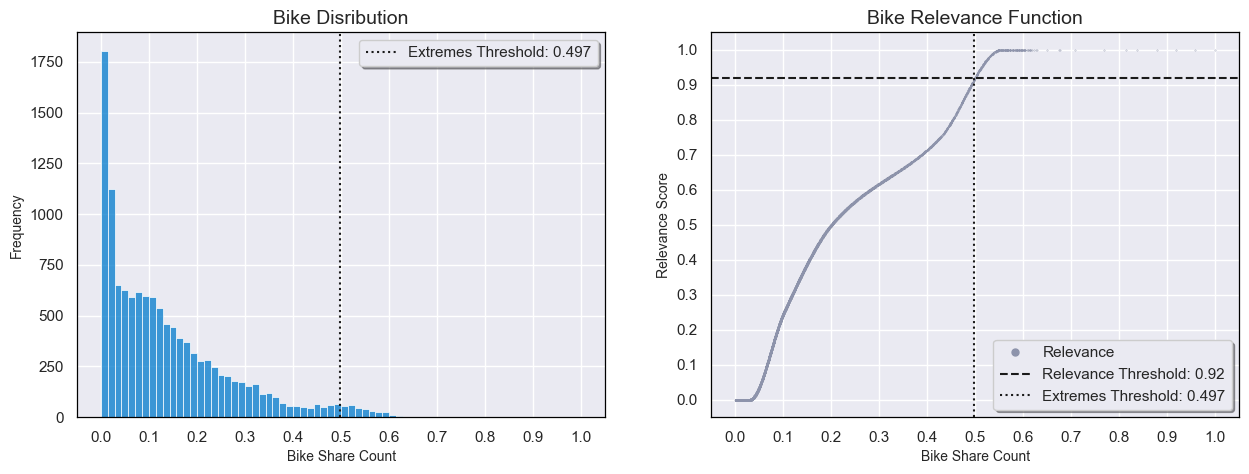

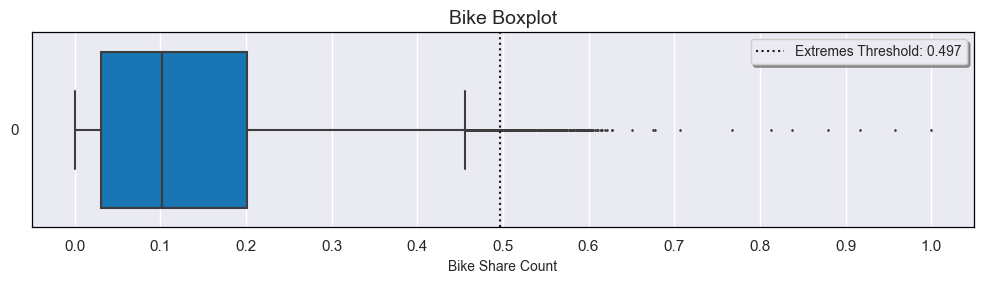

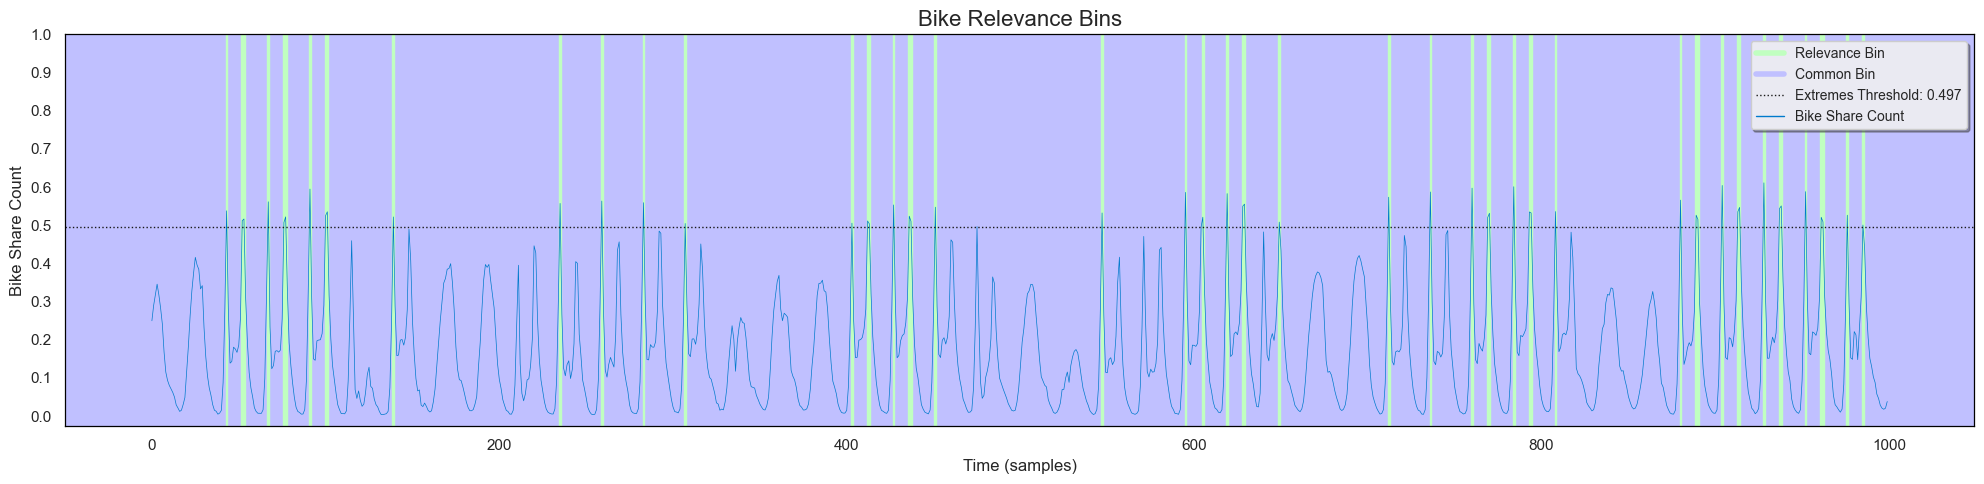

In [24]:
import plt_utils as pu
importlib.reload(pu)
#pu.PlotScaledData(data, TVAR)
#import plt_utils as pu
#importlib.reload(pu)
r_Y_plot = RELEVANCE_FUNCTION.__call__(all_train_targets) #relevance for plotting
k_Y_plot = [val >= RELEVANCE_THRESHOLD for val in r_Y_plot]
r_Y_plot = np.array(r_Y_plot)
k_Y_plot = np.array(k_Y_plot)

pu.PlotRelevance(all_train_targets, r_Y_plot, RELEVANCE_THRESHOLD, EXTREMES_THRESHOLD, TVAR, DATA_NAME)
#pu.PlotRelevance(Y_train.mean(axis=1), r_Y, RELEVANCE_THRESHOLD)
#pu.PlotRelevance(Y_train.max(axis=1), r_Y, RELEVANCE_THRESHOLD)

#Plots Loss Surfaces: shows you how the relevance function affects our loss
#pu.PlotCaseWeightSurface(all_train_targets, RELEVANCE_FUNCTION, EXTREMES_THRESHOLD, 0.5, TVAR)
#pu.PlotUtilitySurface(all_train_targets, RELEVANCE_FUNCTION, EXTREMES_THRESHOLD, 0.5, TVAR)

#pu.PlotBins(all_train_targets,k_Y_plot,EXTREMES_THRESHOLD, TVAR, DATA_NAME)
pu.PlotBins(all_train_targets[3000:4000],k_Y_plot[3000:4000],EXTREMES_THRESHOLD, TVAR, DATA_NAME)

**Resampling**

**Oversampling using relevance bin based SMOTER**

relBinResample is the function used to perform relevance bin based SMOTER as described in "Resampling Strategies for Imbalanced Time Series". In this strategy, synthetic cases are interpolated from a seed sample and a 
randomly chosen k-nearest neighbor situated in the same relevance bin as the seed. Variations to this SMOTER algorithm include:
* Relevance-bin based SMOTER with Temporal Bias **(SM_T)**: greater preference for choosing more recent samples amongst the k-nearest neighbors in the relevance bin
* Relevance-bin based SMOTER with Relevance Bias **(SM_Phi)**: greater preference for choosing samples with a higher relevance score amongst the k-nearest neighbors in the relevance bin
* Relevance-bin based SMOTER with Temporal and Relevance Bias **(SM_TPhi)**: combination of **SM_T** and **SM_Phi**

Note: synthetic cases are not generated for relevance bins that contain only one sample

**Oversampling using a regular SMOTER approach**

regularResample was the original resampling function written by Bhavya. It performs SMOTE without the concept of relevance bins using the SMOTE class from Imblearn. Hence, a synthetic case could be generated by interpolating from two samples observed at very different points in time. In this project we were interested in comparing these two different approaches.

**Undersampling**

We currently haven't investigated how applying an undersampling approach will effect predictive performance.



In [26]:
RES_STRATS = ["SMOTER_bin"]#, "SMOTER_bin_t", "SMOTER_bin_r", "SMOTER_bin_tr", "SMOTER_regular", "GAN_CNN", "GAN_FNN"]

**Define GAN Models**

In [27]:
#import GAN as gmod
#importlib.reload(gmod)

n_gan_epochs = 11 #100
gan_batch_size = 128 #128
CNN_GENS=None; CNN_DISCS=None; FNN_GENS=None; FNN_DISC=None
if "GAN_CNN" in RES_STRATS:
    CNN_GENS, CNN_DISCS = gmod.getGAN(k_Xex,GAN_CNN_DIR, "CNN", SAMPLE_DIM, n_gan_epochs, gan_batch_size, RECORDER.log_print)
if "GAN_FNN" in RES_STRATS:
    FNN_GENS, FNN_DISCS = gmod.getGAN(k_Xex,GAN_FNN_DIR, "FNN", SAMPLE_DIM, n_gan_epochs, gan_batch_size, RECORDER.log_print)

RECORDER.save_param_dict({"GAN":{"nEpochs":n_gan_epochs,"batchSize": gan_batch_size}})

In [28]:
#import SMOTER as smtr
#importlib.reload(smtr)

#import GAN as gmod
#importlib.reload(gmod)
K_SMOTE_NEIGHBORS = 3

def run_resampling(k_x, k_y, r_y, res_strats, relevance_function, relevance_threshold):
    resampling_results = {}    
    
    _, orig_rels, orig_coms = smtr.countRelVsCom(k_x[:,-N_STEPS_OUT:],relevance_function,relevance_threshold)
    print(f"need to gen {orig_coms} new rares")
    #Perform each variation of each resampling approach
    if "SMOTER_bin" in res_strats:
        resampling_results['SMOTER_bin'] = smtr.relBinResample(k_x, k_y, orig_coms, r_y, K_SMOTE_NEIGHBORS)
        RECORDER.log_print(f"Finished SMOTER_bin resample")
    if "SMOTER_bin_t" in res_strats:
        resampling_results["SMOTER_bin_t"] = smtr.relBinResample(k_x, k_y, orig_coms, r_y, K_SMOTE_NEIGHBORS, temp_bias=True)
        RECORDER.log_print("Finished SMOTER_bin_t resample")
    if "SMOTER_bin_r" in res_strats:
        resampling_results['SMOTER_bin_r'] = smtr.relBinResample(k_x, k_y, orig_coms, r_y, K_SMOTE_NEIGHBORS, temp_bias=False, rel_bias=True)
        RECORDER.log_print("Finished SMOTER_bin_r resample")
    if "SMOTER_bin_tr" in res_strats:
        resampling_results['SMOTER_bin_tr'] = smtr.relBinResample(k_x, k_y, orig_coms, r_y, K_SMOTE_NEIGHBORS, temp_bias=True, rel_bias=True)
        RECORDER.log_print("Finished SMOTER_bin_tr resample")
    #We want all the resampling approaches to return the same number of relevance and common cases:
    _, num_rel, num_com = smtr.countRelVsCom(resampling_results['SMOTER_bin'][:,-N_STEPS_OUT:],relevance_function,relevance_threshold)
    #print(f"num relevance that reg approach is trying to match {num_rel}")
    if "GAN_CNN" in res_strats:
        for key, gen in CNN_GENS.items():
            resampling_results[f"GAN_CNN_e{key}"] = gmod.ganResample(k_x, 30, gen, "CNN") #for testing
            #resampling_results[f"CNN_GAN_resample_{key}"] = ganResample(k_x, num_rel - orig_rels, gen, "CNN")
            RECORDER.log_print(f"Finished GAN_CNN_e{key}")
    if "GAN_FNN" in res_strats:
        for key, gen in FNN_GENS.items():
            print(type(gen))
            print(type(gen.generator))
            print(f"Input dim of gen: {gen.generator[0][0].in_features}")
            resampling_results[f"GAN_FNN_e{key}"] = gmod.ganResample(k_x, 30, gen, "FNN") #for testing
            #resampling_results[f"FNN_GAN_resample_{key}"] = ganResample(k_x, num_rel - orig_rels, gen, "FNN")
            RECORDER.log_print(f"Finished GAN_FNN_e{key}")
        
    if "SMOTER_regular" in res_strats:
        resampling_results['SMOTER_regular'], yyyy = smtr.regularResample(k_x, k_y, num_rel, num_com, K_SMOTE_NEIGHBORS)
        RECORDER.log_print("Finished SMOTER_regular")
    strat_meta = [['Resampling Method','Num Relevant','Num Common','Total']]
    for strat in resampling_results.keys():
        tot, num_rel, num_com = smtr.countRelVsCom(resampling_results[strat][:,-N_STEPS_OUT:],relevance_function,relevance_threshold)
        tab_row = [strat,str(num_rel),str(num_com),str(tot)]
        strat_meta.append(tab_row)
    tab_row = ["no_resample",str(orig_rels),str(orig_coms),str(orig_rels+orig_coms)]
    strat_meta.append(tab_row)
    
    RECORDER.log_print("Resampled sizes: \n"+tabulate(strat_meta,headers='firstrow',tablefmt='grid'))
    #RECORDER.save_sample_results_step(resampling_results, N_STEPS_IN, N_FVARS, FVARS, TVAR)
    RECORDER.save_param_dict({"SMOTE":{"kNeighbors":K_SMOTE_NEIGHBORS}})
    
    return resampling_results


#Moved where we define RES_STRATS to before we train the GANS
resampling_results = run_resampling(k_X, k_Y, r_Y, RES_STRATS, RELEVANCE_THRESHOLD, RELEVANCE_FUNCTION)

need to gen 11867 new rares
LOG: 16:02:50:409 Finished SMOTER_bin resample

LOG: 16:02:50:414 Resampled sizes: 
+---------------------+----------------+--------------+---------+
| Resampling Method   |   Num Relevant |   Num Common |   Total |
+=====================+================+==============+=========+
| SMOTER_bin          |          12137 |        11867 |   24004 |
+---------------------+----------------+--------------+---------+
| no_resample         |            318 |        11867 |   12185 |
+---------------------+----------------+--------------+---------+



**Init Evaluator object for model eval metrics**

In [29]:
import evaluator as ev
importlib.reload(ev)
#NOTE: evaler_params must include CaseWeight else errors in MODEL_LSTM
evaluator_params = { "RMSE": {},
                     "RMSERare": {},
                     "Utility": {'m':0.5},
                     "CaseWeight": {'m':0.5},
                     "PrecisionRecall": {},
                     "FScore": {'beta':0.5},
                     #"RelevanceROC": {},
                   }
EVALER = ev.Evaluator(evaluator_params, RELEVANCE_THRESHOLD, RELEVANCE_FUNCTION)
RECORDER.save_param_dict({"Evaluator":evaluator_params})

**Train and evaluate an LSTM for each data set**

In [30]:
def main(time_step, X_train, X_test, Y_train, Y_test, resampling_results, evaler, recorder, train_params):   
    recorder.log_print(f"Starting forecasting experiments with num_exps: {train_params['num_exp']} and epochs: {train_params['epochs']}")
    recorder.save_param_dict({"Forecasting":{"NumExp":train_params['num_exp'], "nEpochs": train_params['epochs'], "hidden":train_params['hidden']}})
    
    print(f"############## no_resample ##############")
    best_predict_test, best_predict_train, best_cw, best_model = fmod.MODEL_LSTM(X_train, X_test, Y_train, Y_test, "no_resample", train_params, evaler, recorder.log_print)
    #predict_test, predict_train = train_eval(X_train, X_test, Y_train, Y_test, "no_resample", train_params, evaler)    
    forecast_results = {}
    results = {'predict_test':best_predict_test,'predict_train':best_predict_train,'X_train':X_train,'Y_train':Y_train,'model':best_model}
    forecast_results['no_resample'] = results
    for key in resampling_results.keys():
        res = resampling_results[key]
        X_res = res[:,:(N_STEPS_IN*N_FVARS)]
        X_res = X_res.reshape((X_res.shape[0],N_STEPS_IN,N_FVARS))
        Y_res = res[:,(N_STEPS_IN*N_FVARS):]
        print(f"############## {key} ##############")
        best_predict_test, best_predict_train, best_cw, best_model = fmod.MODEL_LSTM(X_res, X_test, Y_res, Y_test, key, train_params, evaler, recorder.log_print)
        #predict_test, predict_train = train_eval(X_res, X_test, Y_res, Y_test, key, train_params, evaler)
        results = {'predict_test':best_predict_test,'predict_train':best_predict_train,'X_train':X_res,'Y_train':Y_res,'model':best_model}
        forecast_results[key] = results
    return forecast_results

TRAIN_PARAMS = {
        'num_exp': 2, 
        'n_steps_in': N_STEPS_IN,
        'n_steps_out': N_STEPS_OUT,
        'epochs': 1,
        'hidden': 10,
        'forecast_dir': FORECAST_DIR,
        'n_fvars': N_FVARS
    }

forecast_results = main(N_STEPS_IN, X_train, X_test, Y_train, Y_test, resampling_results, EVALER, RECORDER, TRAIN_PARAMS)

print("$$$$ FINISHED FORECASTING EXPERIMENTS $$$$")

LOG: 16:02:58:697 Starting forecasting experiments with num_exps: 2 and epochs: 1

############## no_resample ##############
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense (Dense)               (None, 2)                 22        
                                                                 
Total params: 502 (1.96 KB)
Trainable params: 502 (1.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
LOG: 16:02:58:877 Starting training on no_resample

LOG: 16:02:58:877 	Experiment 1 in progress

164/164 [==============================] - 0s 1ms/step
LOG: 16:03:02:200 	Experiment 2 in progress

164/164 [==============================] - 0s 1ms/step
LOG: 16:03:03:633 Total time for 2 no_resampl

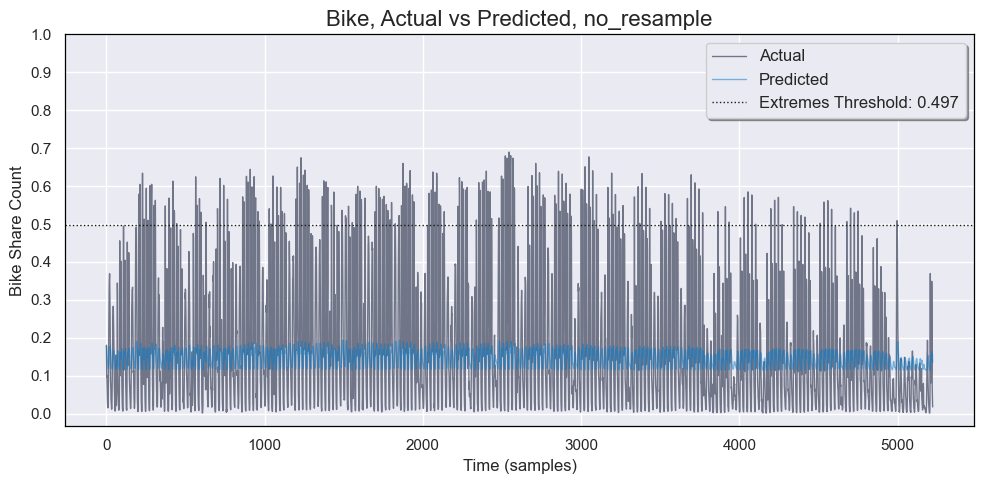

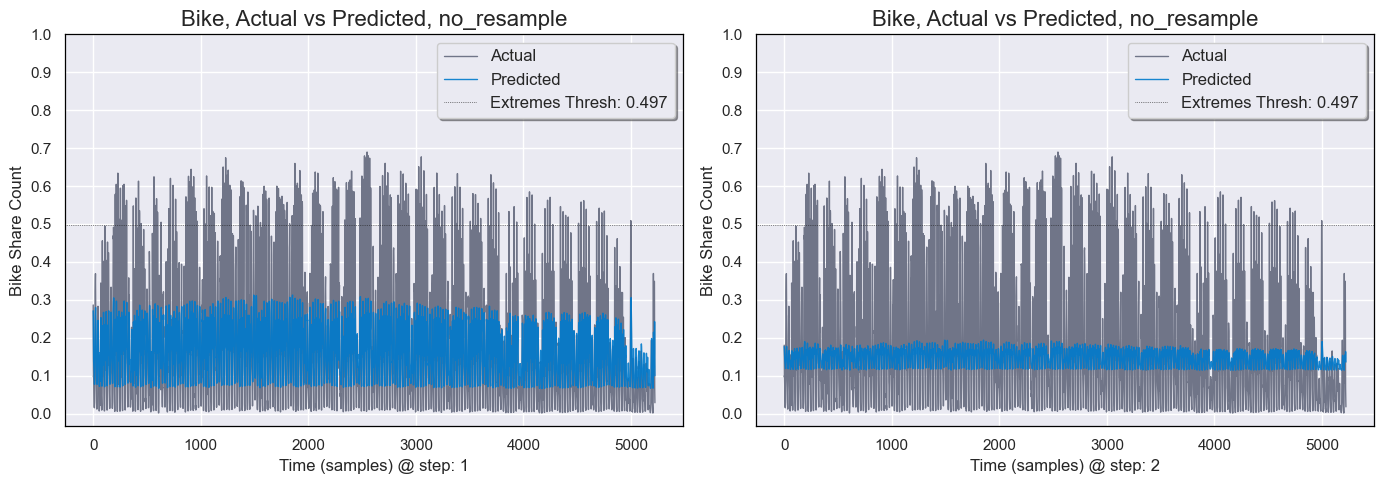

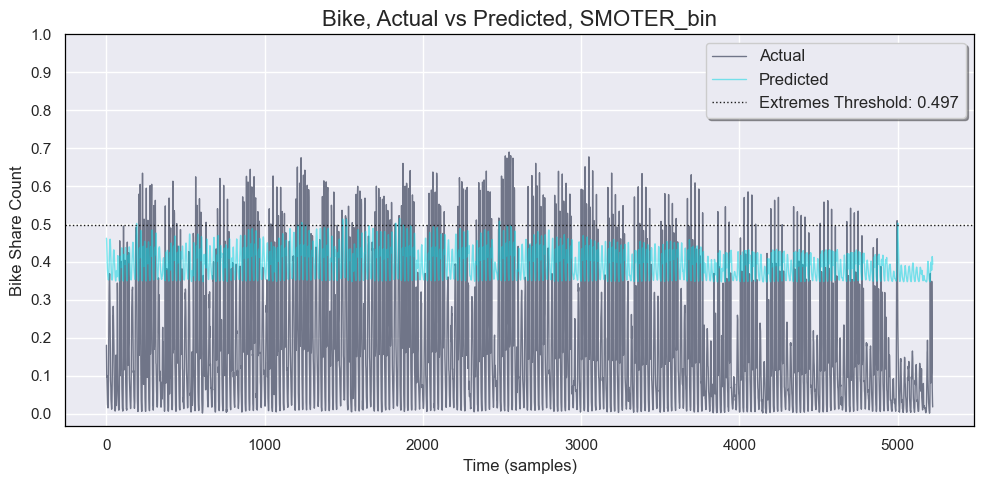

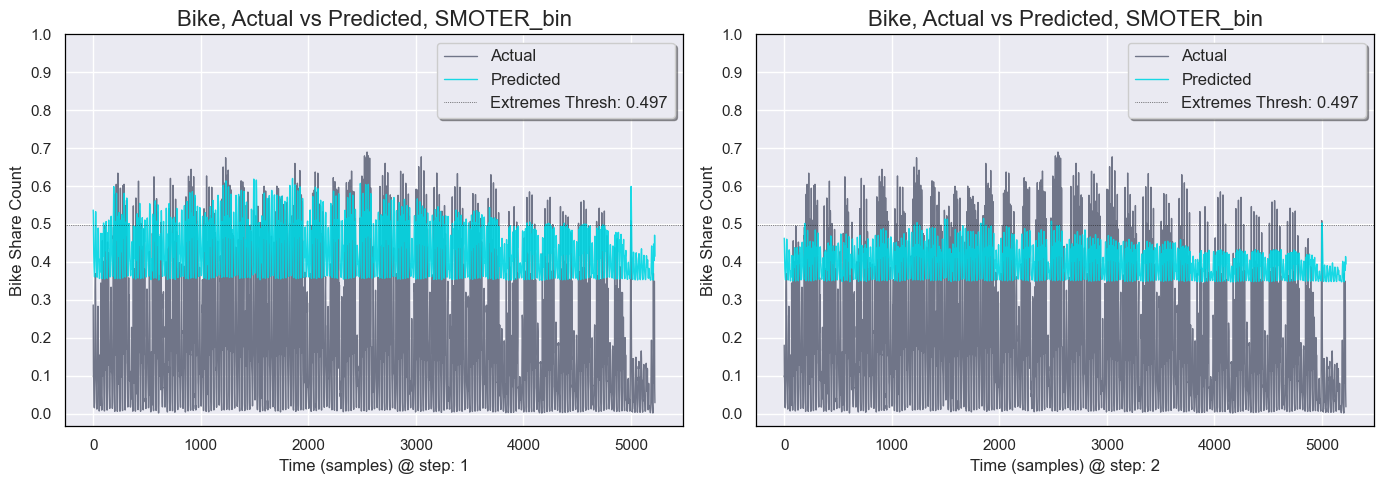

In [31]:
import plt_utils as pu
importlib.reload(pu)

RECORDER.save_all_evaler_exps(EVALER.getResultsDf())

#PLOT PRED VS ACTUAL + SAVE_EVAL_RESULTS
for key in forecast_results.keys():
    y_predict_test = forecast_results[key]['predict_test']
    pu.PlotPredVsActual1D(Y_test, y_predict_test, key, EXTREMES_THRESHOLD, TVAR, DATA_NAME, 1)
    pu.PlotPredVsActualSteps(Y_test, y_predict_test, key, EXTREMES_THRESHOLD, TVAR, DATA_NAME, N_STEPS_OUT)
    RECORDER.save_LSTM(forecast_results[key]['model'], key)

**Record KS Statistic and Plot Individual Extremes Distribution**

KS statistic: 0.13615390953283346, p-value: 1.7892914722164432e-05


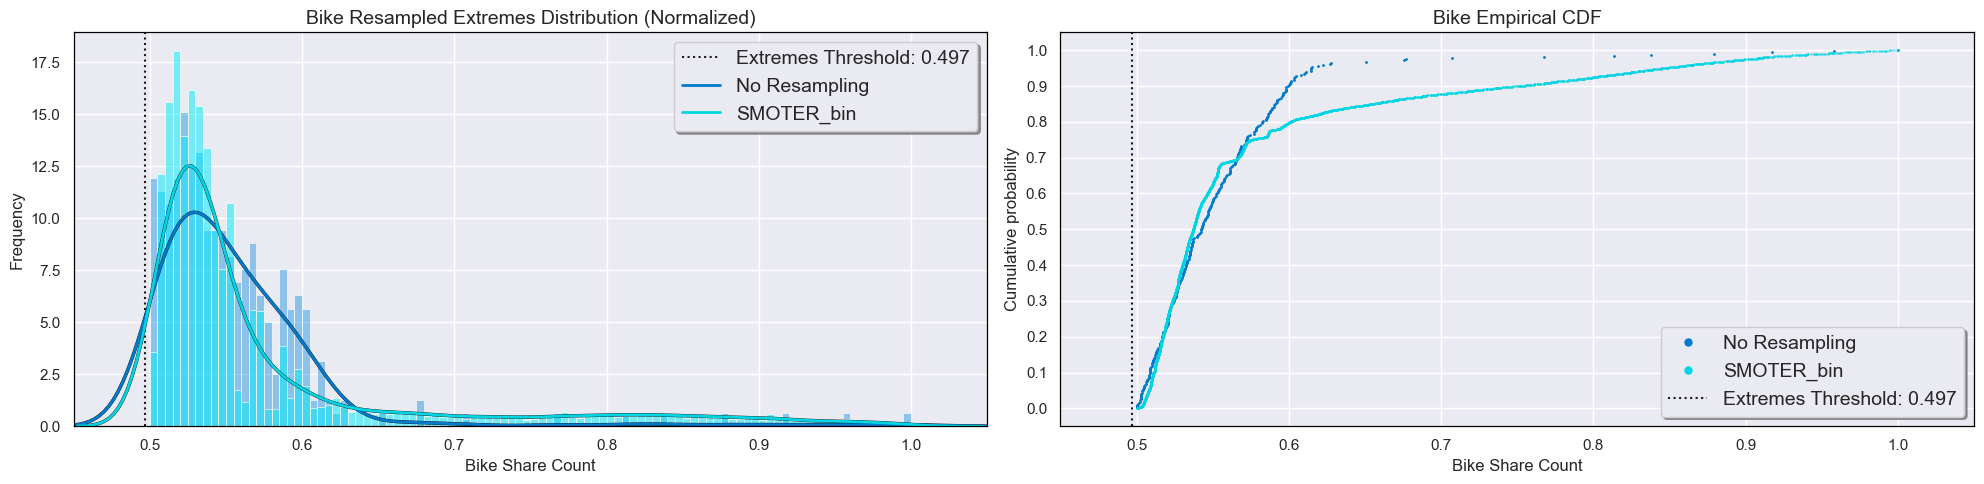

In [32]:
from scipy.stats import ks_2samp
import scipy.stats as stats
import plt_utils as pu
importlib.reload(pu)
step_out = 0
y_orig_rel = RELEVANCE_FUNCTION.__call__(Y_train[:,step_out])
rare_mask = [val >= RELEVANCE_THRESHOLD for val in y_orig_rel]
y_orig_rare = Y_train[rare_mask]
ks_results = []
for key, res in resampling_results.items():
    y_res = res[:,(N_STEPS_IN*N_FVARS):]
    y_rel = RELEVANCE_FUNCTION.__call__(y_res[:,step_out])
    rare_mask = [val >= RELEVANCE_THRESHOLD for val in y_rel]
    y_rare = y_res[rare_mask]

    # Perform the Kolmogorov-Smirnov test
    statistic, p_value = ks_2samp(y_orig_rare[:,step_out], y_rare[:,step_out])
    print(f"KS statistic: {statistic}, p-value: {p_value}")
    ks_results.append({'Res':key, 'ksStat':statistic, 'pValue':p_value})

    pu.PlotExremesDistribution(y_orig_rare, y_rare, key, step_out, EXTREMES_THRESHOLD, TVAR, DATA_NAME)
    

ks_df = pd.DataFrame(ks_results)
RECORDER.save_ks(ks_df)

**Prepare Data for Comparison Plots**

If we include all strategies on the comparison plots they will be extremely cluttered and almost useless to the reader. In the following cell we choose the best CNN_GAN, FNN_GAN, and SMOTER_bin approach from the caseWeight of the forecasting results and only include these on the comparison plots. 

Later we'll also use this cell to load the base resampling results / eval metrics to include on the comparison plots along side the next generation of resampling strategies

In [33]:
#determine which CNN and FNN GAN models performed best according to the decider variable
#make a new dict 'best_resampling_results' which discards all other CNN and FNN GAN models 

def calculate_mean(lst):
    return sum(lst) / len(lst)

#Combine EVALER from loaded experiments
#Combine resampling results from loaded experiments
#np.loadtxt('test.txt', delimiter=',', dtype=float)

exp_sum = EVALER.getExperimentSummaryDf('CaseWeight')
best_resampling_results = resampling_results.copy()
best_cnn_gan = ""
best_fnn_gan = ""
best_bin = ""
cnn_exp_sum = exp_sum[exp_sum['Res'].str.contains("GAN_CNN")]
if not cnn_exp_sum.empty:
    #apply mean to all rows
    cnn_exp_sum["CaseWeight_Test_Mean"] = cnn_exp_sum[f"CaseWeight_Test_Mean"].apply(calculate_mean)
    max_cw_idx = cnn_exp_sum["CaseWeight_Test_Mean"].idxmin()
    best_cnn_gan = cnn_exp_sum.at[max_cw_idx, "Res"]
    print(f"Best CNN_GAN: {best_cnn_gan}")
    keys_to_delete = [key for key in best_resampling_results.keys() if "GAN_CNN" in key and key != best_cnn_gan]
    print(f"deleting keys: {keys_to_delete}")
    for key in keys_to_delete:
        del best_resampling_results[key]
    ekey = int(best_cnn_gan.split('_')[-1][1:])
    RECORDER.save_gan(CNN_GENS[ekey], CNN_DISCS[ekey], "CNN", best_cnn_gan)

fnn_exp_sum = exp_sum[exp_sum['Res'].str.contains("GAN_FNN")]
if not fnn_exp_sum.empty:
    #apply mean to all rows
    fnn_exp_sum["CaseWeight_Test_Mean"] = fnn_exp_sum[f"CaseWeight_Test_Mean"].apply(calculate_mean)
    max_cw_idx = fnn_exp_sum["CaseWeight_Test_Mean"].idxmin()
    best_fnn_gan = fnn_exp_sum.at[max_cw_idx, "Res"]
    print(f"Best FNN_GAN: {best_fnn_gan}")
    keys_to_delete = [key for key in best_resampling_results.keys() if "GAN_FNN" in key and key != best_fnn_gan]
    print(f"deleting keys: {keys_to_delete}")
    for key in keys_to_delete:
        del best_resampling_results[key]
    ekey = int(best_fnn_gan.split('_')[-1][1:])
    RECORDER.save_gan(FNN_GENS[ekey], FNN_DISCS[ekey], "FNN", best_fnn_gan)

bin_exp_sum = exp_sum[exp_sum['Res'].str.contains("SMOTER_bin")] 
if not bin_exp_sum.empty:
    bin_exp_sum["CaseWeight_Test_Mean"] = bin_exp_sum[f"CaseWeight_Test_Mean"].apply(calculate_mean)
    max_cw_idx = bin_exp_sum["CaseWeight_Test_Mean"].idxmin()
    best_bin = bin_exp_sum.at[max_cw_idx, "Res"]
    print(f"Best SMOTER bin: {best_bin}")
    keys_to_delete = [key for key in best_resampling_results.keys() if "SMOTER_bin" in key and key != best_bin]
    print(f"deleting keys: {keys_to_delete}")
    for key in keys_to_delete:
        del best_resampling_results[key]
    
#save resampling results
RECORDER.save_resample_results_np(best_resampling_results)

#load all resampling results
#COMBINE_RESAMPLING_RESULTS_DIR = Path("Sessions/Bike/2023-October-13 13-41-03-532984").joinpath("resample_results")

#resample_results
#best_resampling_results.update({file.stem: np.loadtxt(file, delimiter=',', dtype=float)
#                  for file in COMBINE_RESAMPLING_RESULTS_DIR.iterdir() if file.is_file()})

Best SMOTER bin: SMOTER_bin
deleting keys: []


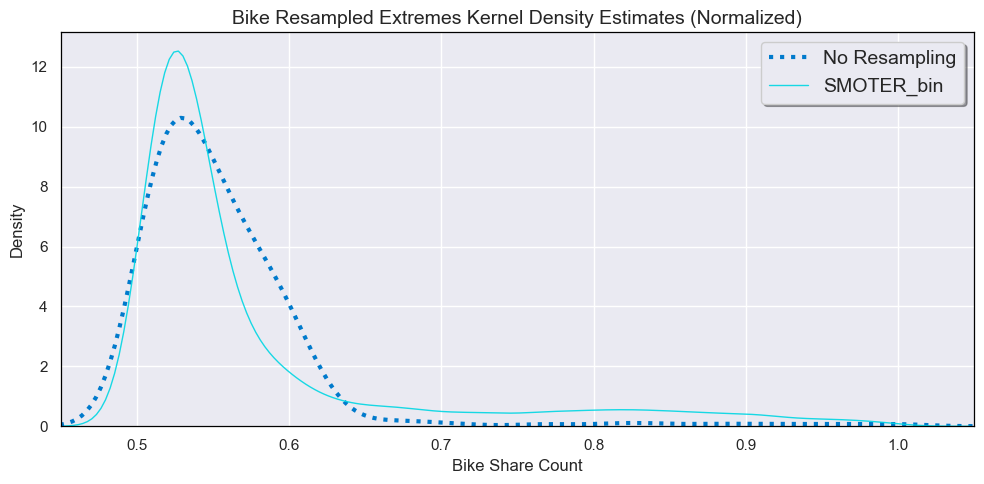

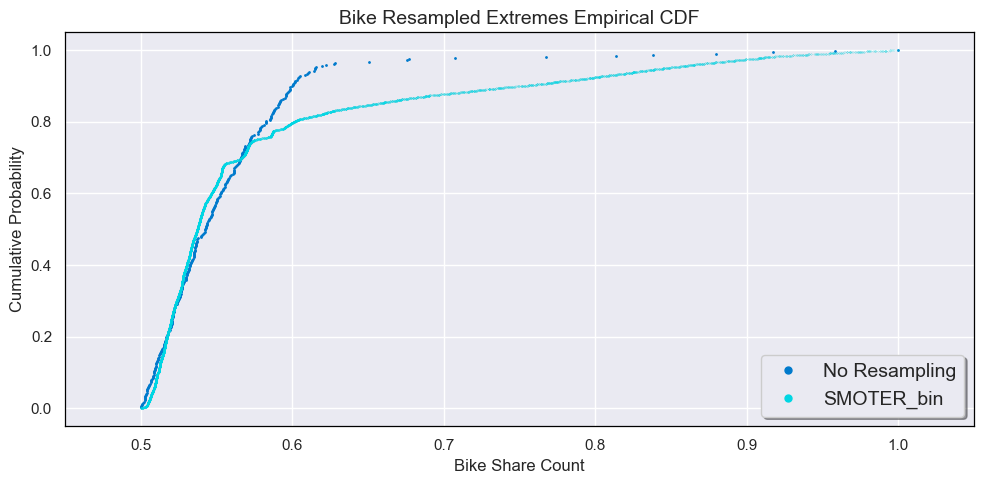

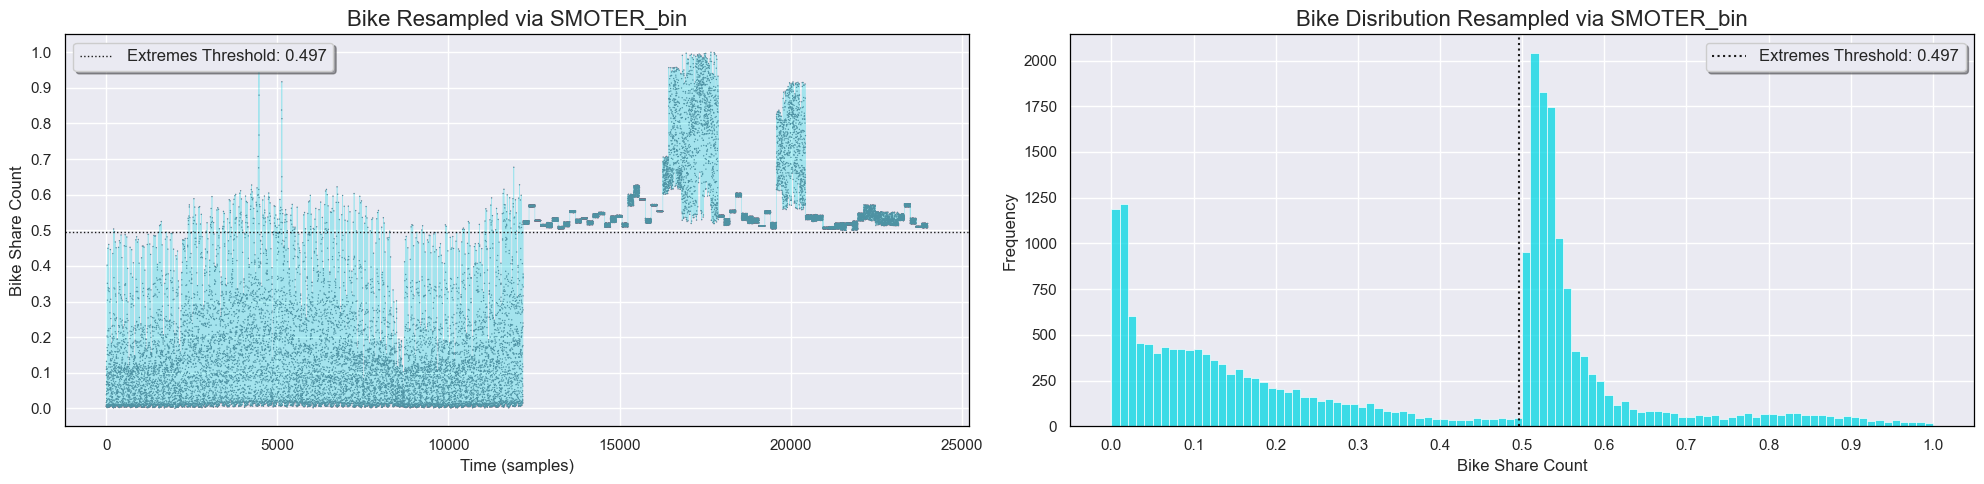

In [34]:
import plt_utils as pu
importlib.reload(pu)
step_out = 0


pu.PlotKDSCompare(Y_train, best_resampling_results, RELEVANCE_FUNCTION, RELEVANCE_THRESHOLD, step_out, N_STEPS_IN*N_FVARS, EXTREMES_THRESHOLD, TVAR, DATA_NAME)    
pu.PlotCDFCompare(Y_train, best_resampling_results, RELEVANCE_FUNCTION, RELEVANCE_THRESHOLD, step_out, N_STEPS_IN*N_FVARS, EXTREMES_THRESHOLD, TVAR, DATA_NAME)    
pu.PlotResampledResults(resampling_results, N_STEPS_OUT,EXTREMES_THRESHOLD, TVAR, DATA_NAME)

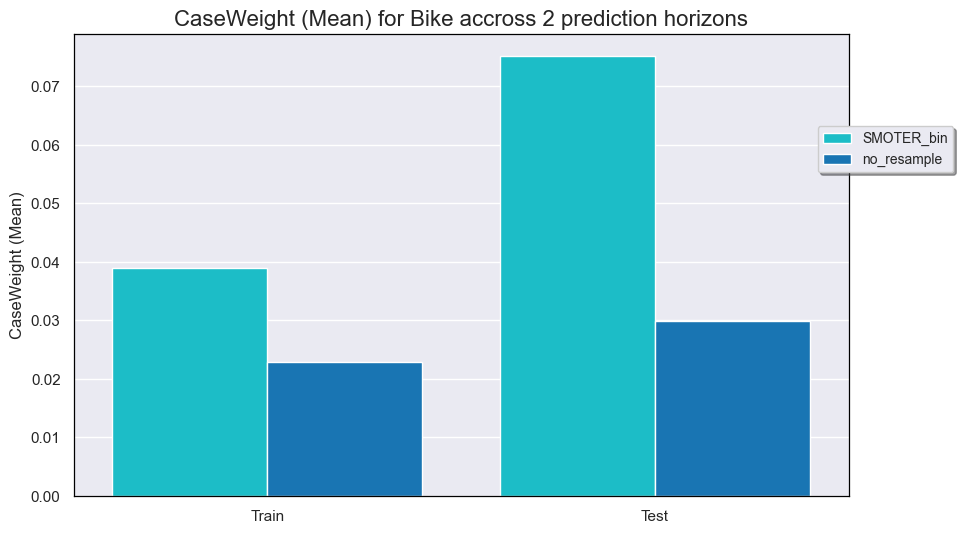

<Figure size 1000x600 with 0 Axes>

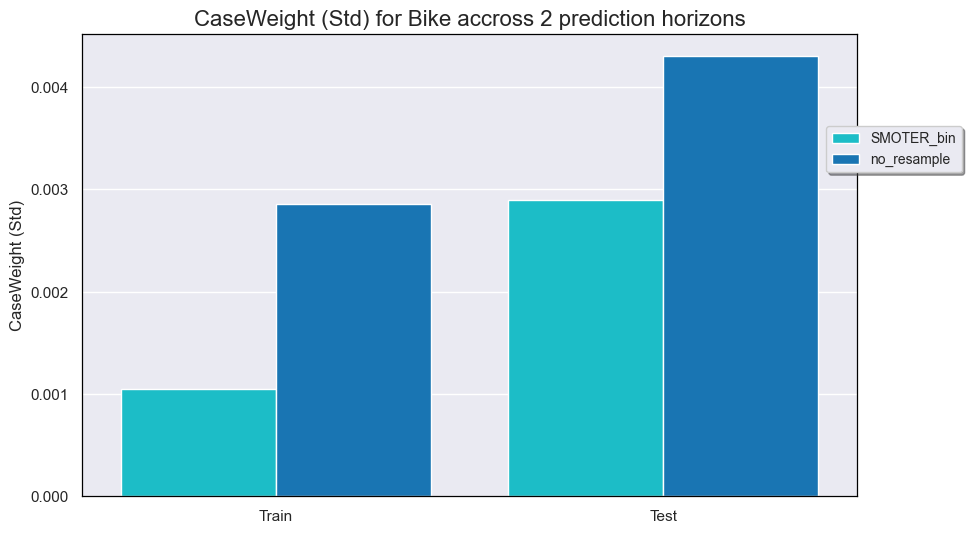

<Figure size 1000x600 with 0 Axes>

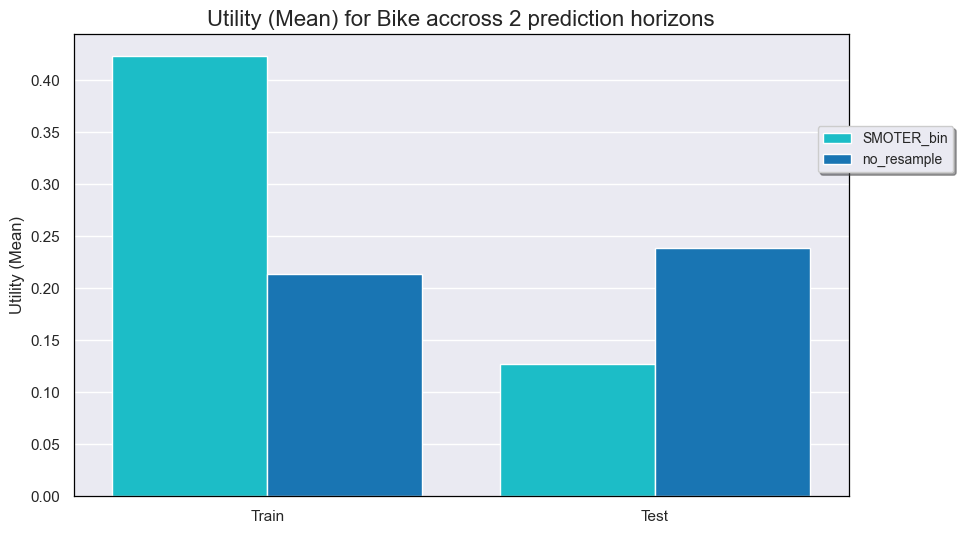

<Figure size 1000x600 with 0 Axes>

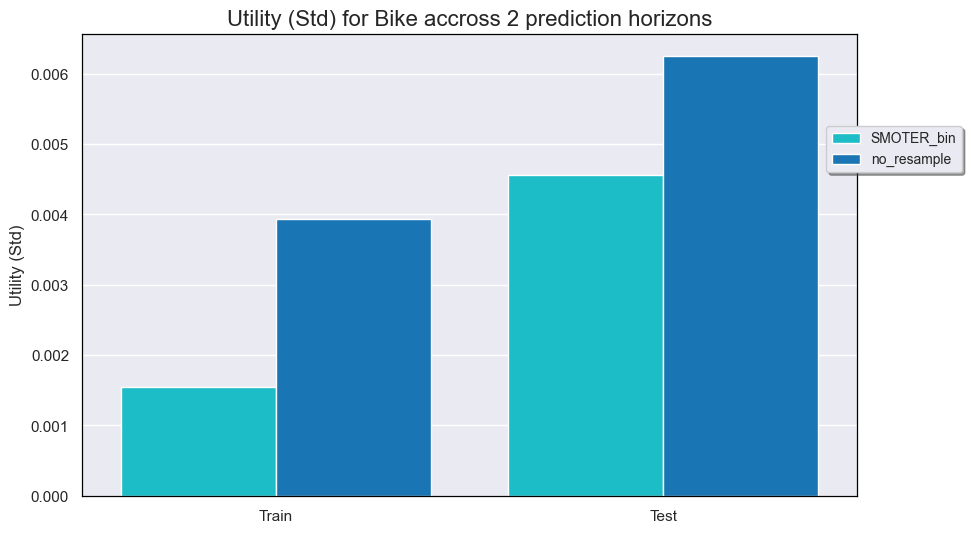

<Figure size 1000x600 with 0 Axes>

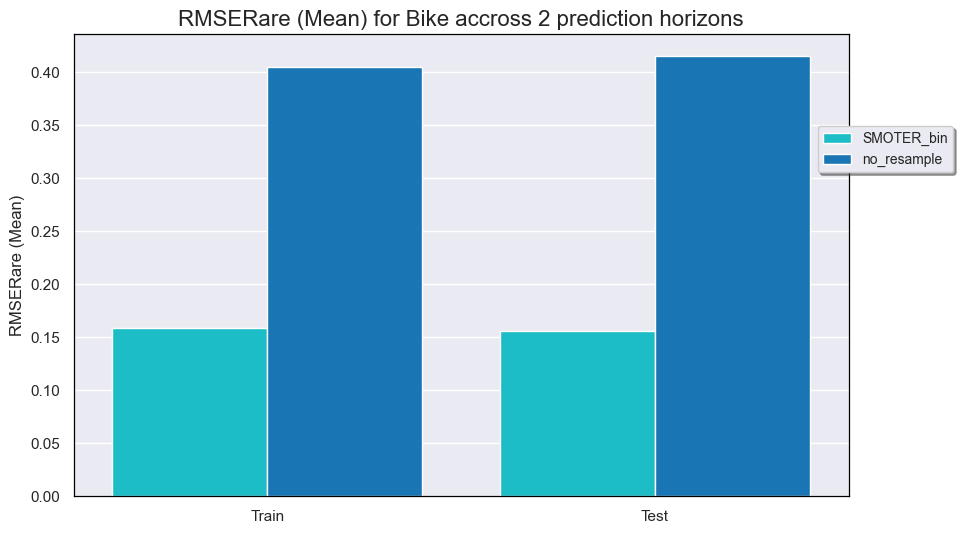

<Figure size 1000x600 with 0 Axes>

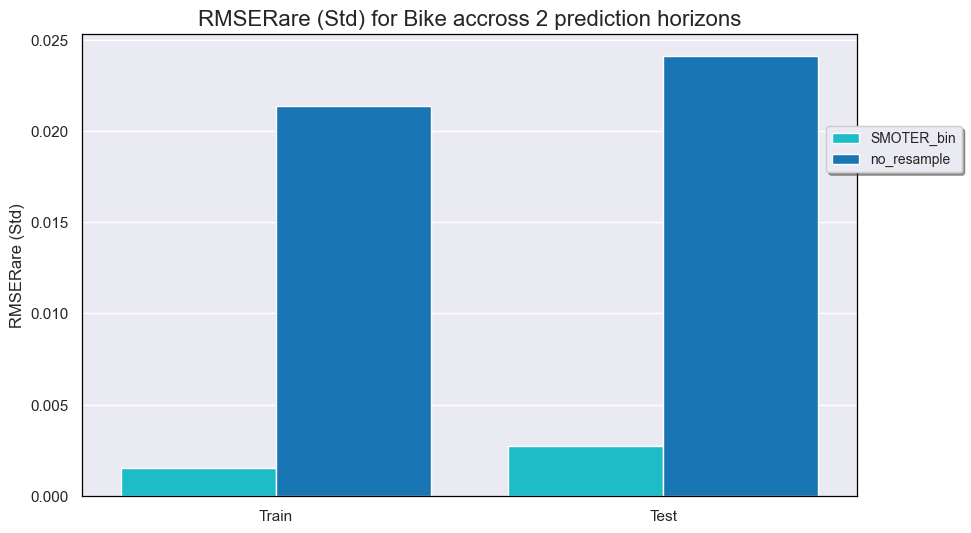

<Figure size 1000x600 with 0 Axes>

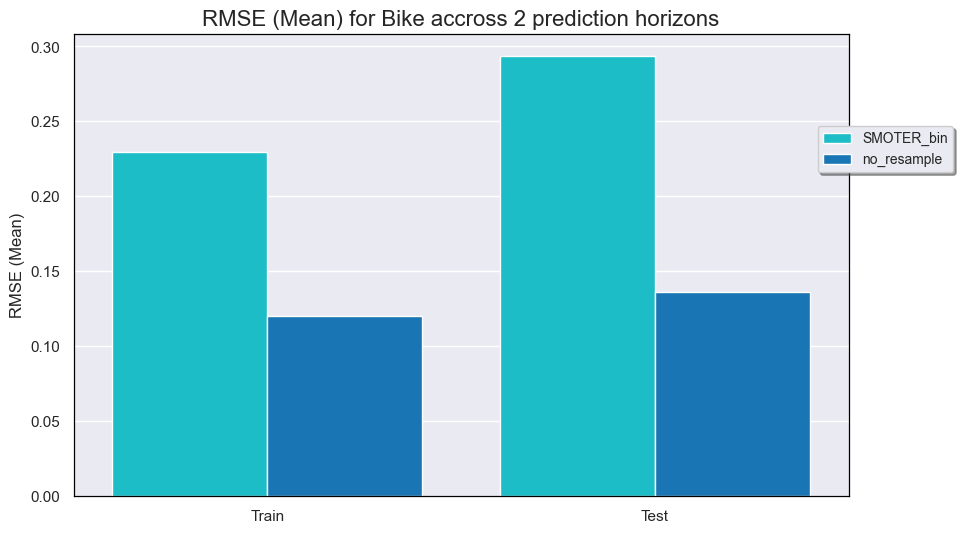

<Figure size 1000x600 with 0 Axes>

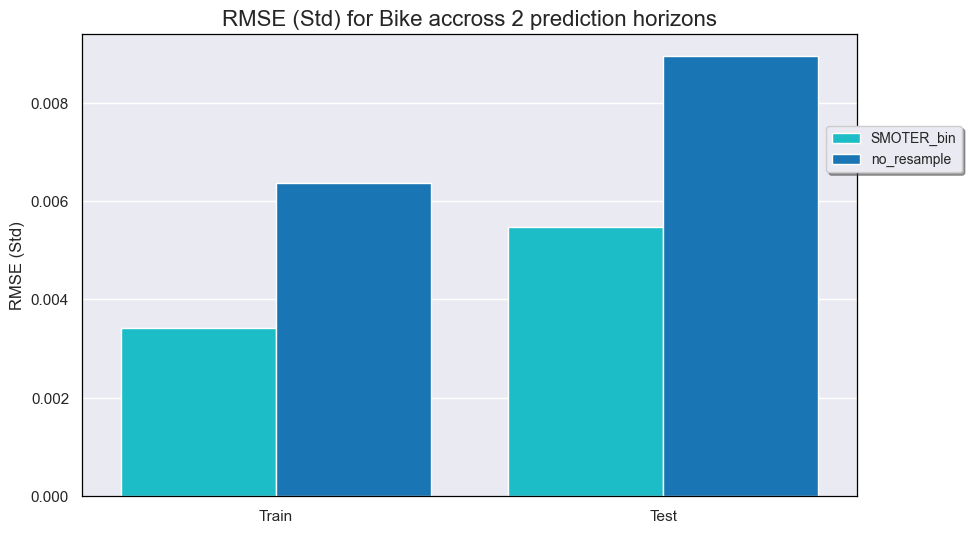

<Figure size 1000x600 with 0 Axes>

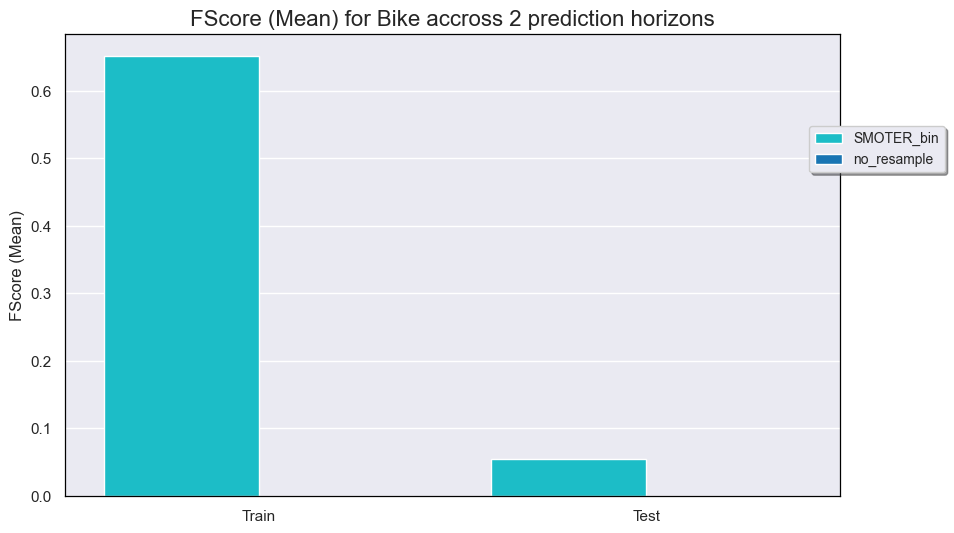

<Figure size 1000x600 with 0 Axes>

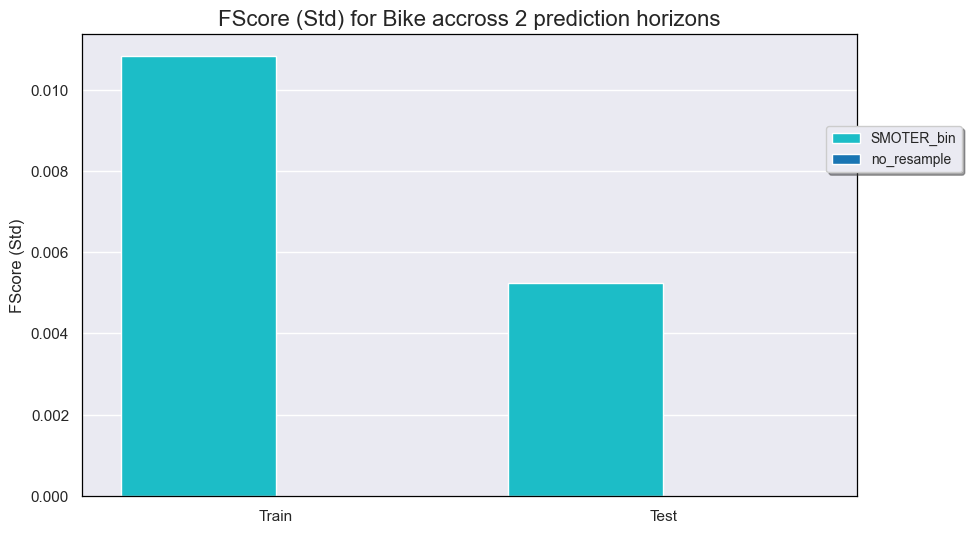

<Figure size 1000x600 with 0 Axes>

In [35]:
import plt_utils as pu
importlib.reload(pu)

#Load eval metrics from previous experiments
#append them to evaler df, 
#Plot Mean/Std of metrics accross all steps
plot_metrics = ["CaseWeight", "Utility", "RMSERare", "RMSE", "FScore"]
ts = ["Train", "Test"]
aggs = ["Mean", "Std"]
def calculate_mean(lst):
    return sum(lst) / len(lst)
for metric in plot_metrics:
    df_results = EVALER.getExperimentSummaryDf(metric, True)
    df_results_train = EVALER.getExperimentSummaryDf(metric, False)
    df_results[f"{metric}_Train_Mean"] = df_results_train[f"{metric}_Train_Mean"]
    df_results[f"{metric}_Train_Std"] = df_results_train[f"{metric}_Train_Std"]
    # Replace with the mean of the steps out lists
    df_results[f"{metric}_Train_Mean"] = df_results[f"{metric}_Train_Mean"].apply(calculate_mean)
    df_results[f"{metric}_Test_Mean"] = df_results[f"{metric}_Test_Mean"].apply(calculate_mean)
    df_results[f"{metric}_Train_Std"] = df_results[f"{metric}_Train_Std"].apply(calculate_mean)
    df_results[f"{metric}_Test_Std"] = df_results[f"{metric}_Test_Std"].apply(calculate_mean)
    for a in aggs:
        filtered_df = df_results[((df_results['Res'].str.contains('GAN_CNN|GAN_FNN')) & ((df_results['Res'] == best_cnn_gan) | (df_results['Res'] == best_fnn_gan))) | (~df_results['Res'].str.contains('GAN_CNN|GAN_FNN'))]
        filtered_df = filtered_df[((filtered_df['Res'].str.contains('SMOTER_bin')) & (filtered_df['Res'] == best_bin)) | (~filtered_df['Res'].str.contains('SMOTER_bin'))]
        '''
        filtered_df = df_results
        if best_cnn_gan:
            filtered_df = filtered_df[((filtered_df['Res'].str.contains('GAN_CNN')) & (filtered_df['Res'] == best_cnn_gan)) | (~filtered_df['Res'].str.contains('GAN_CNN'))]
        if best_fnn_gan:
            filtered_df = filtered_df[((filtered_df['Res'].str.contains('GAN_FNN')) & (filtered_df['Res'] == best_fnn_gan)) | (~filtered_df['Res'].str.contains('GAN_FNN'))]
        '''
        pu.PlotTrainTestBarResults(filtered_df, metric, a, DATA_NAME, N_STEPS_OUT)


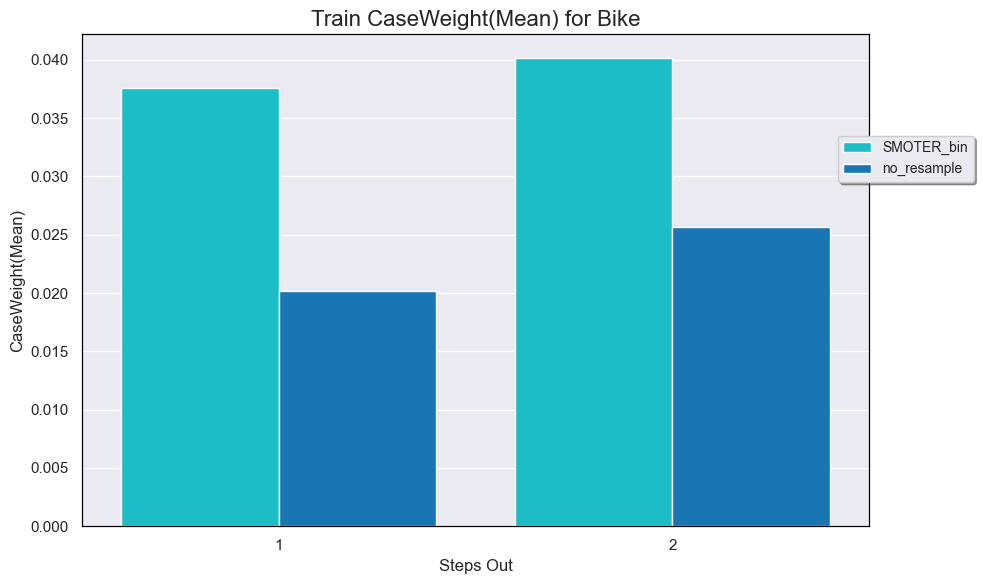

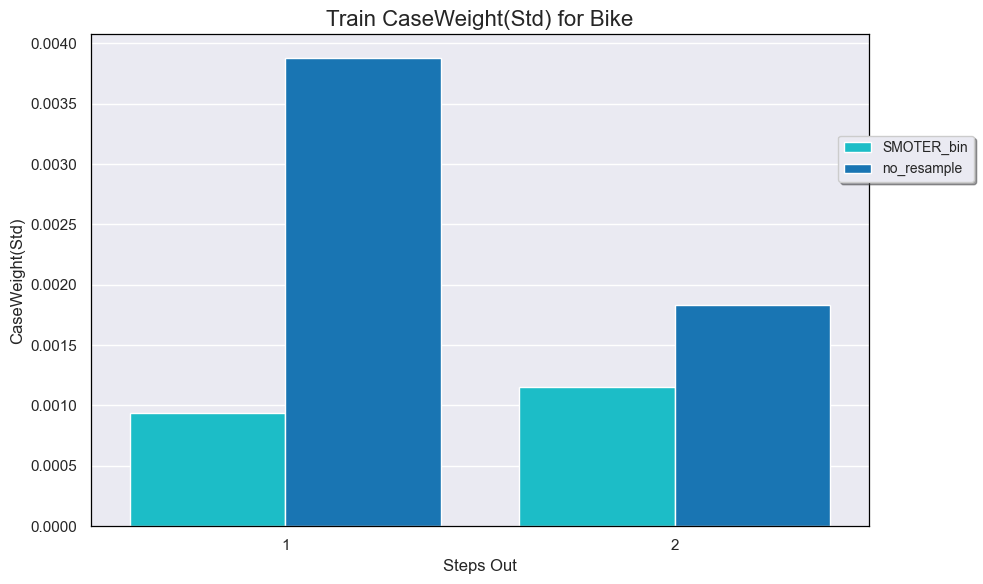

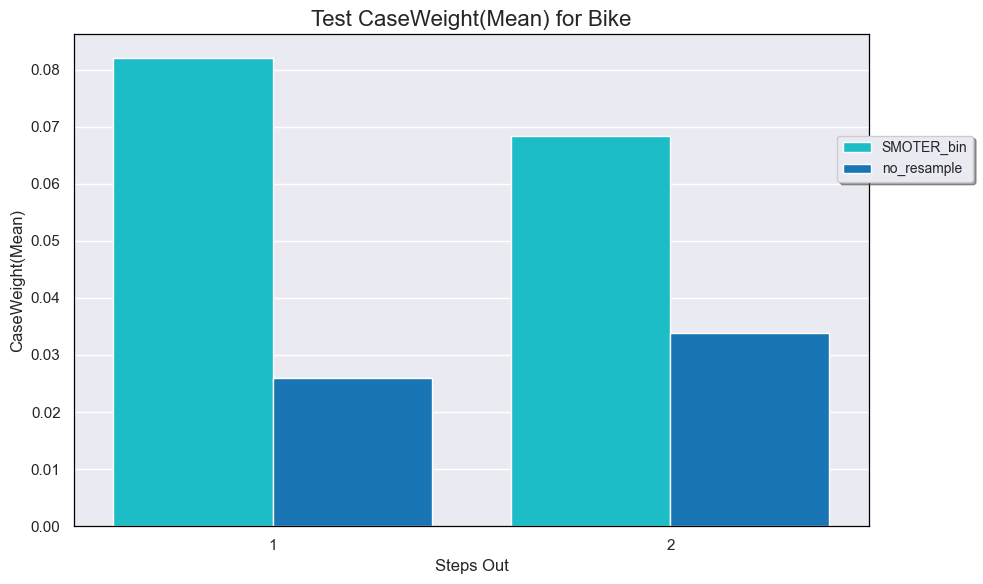

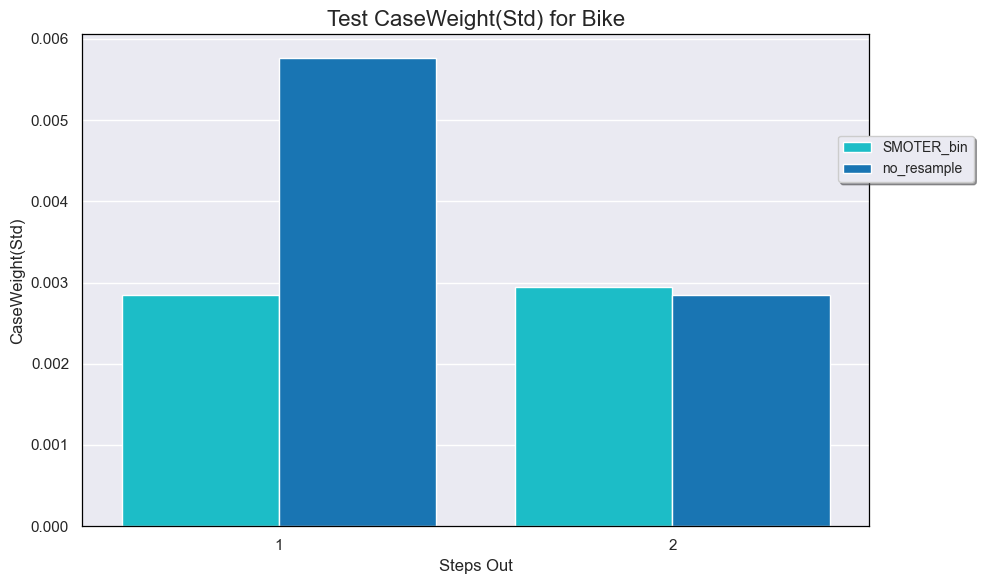

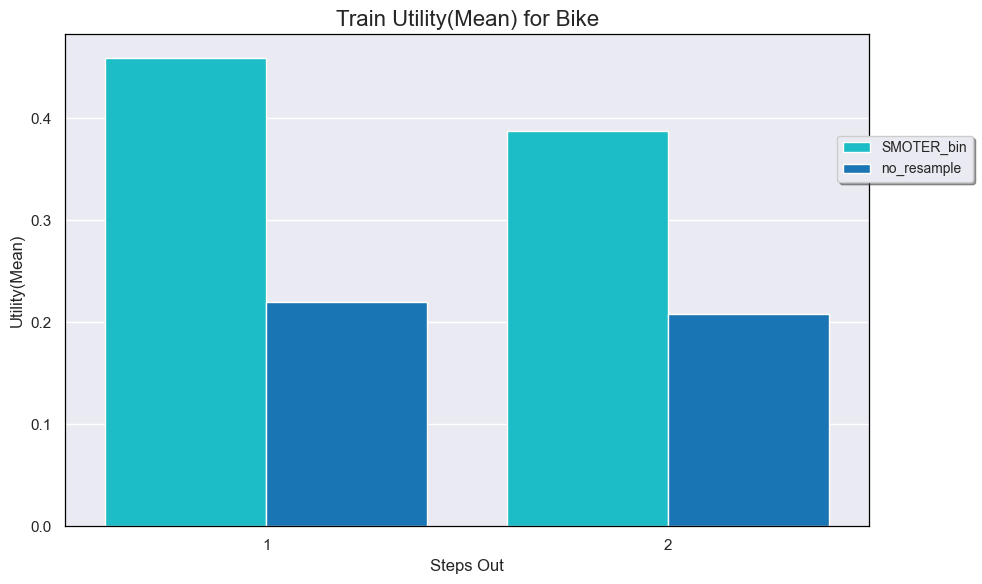

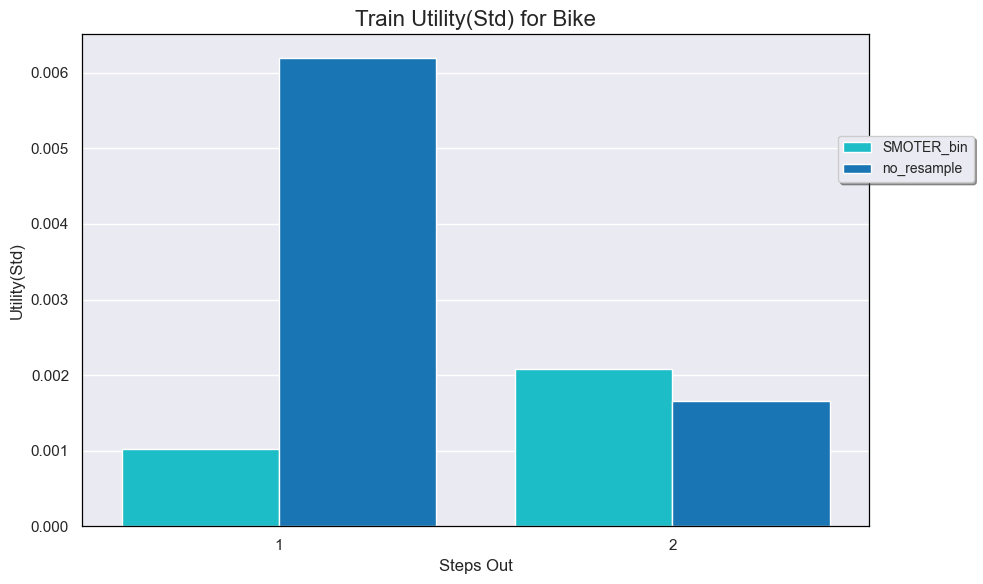

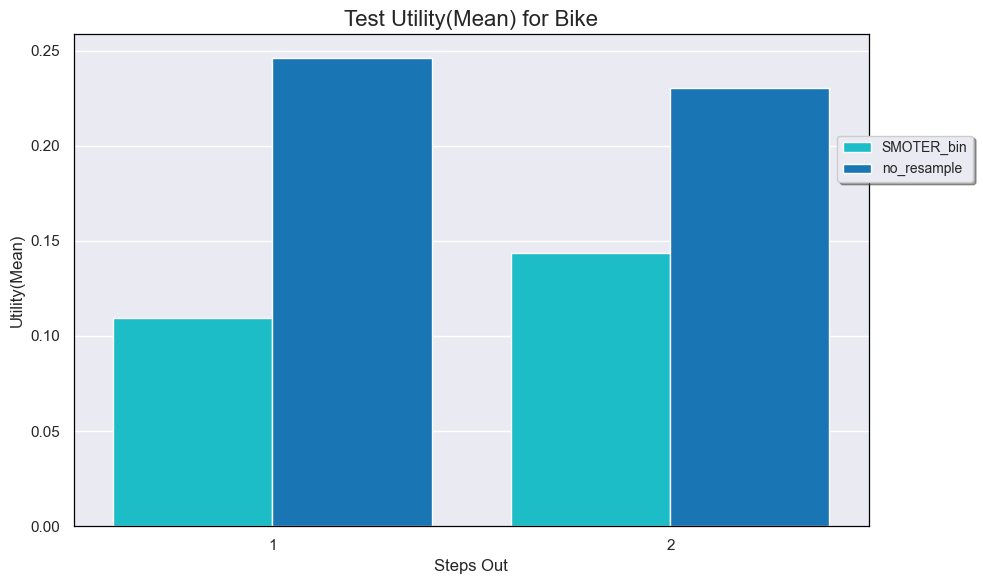

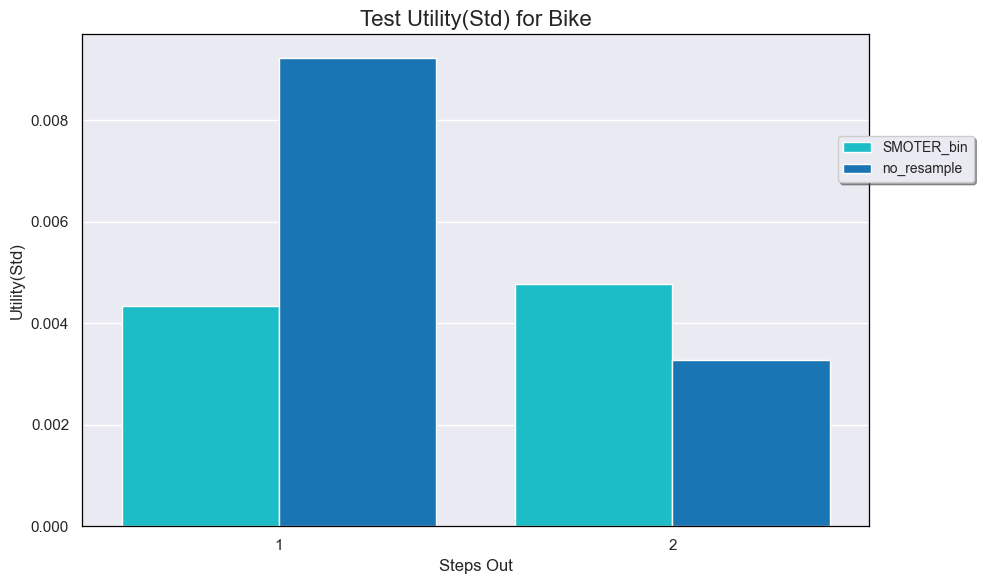

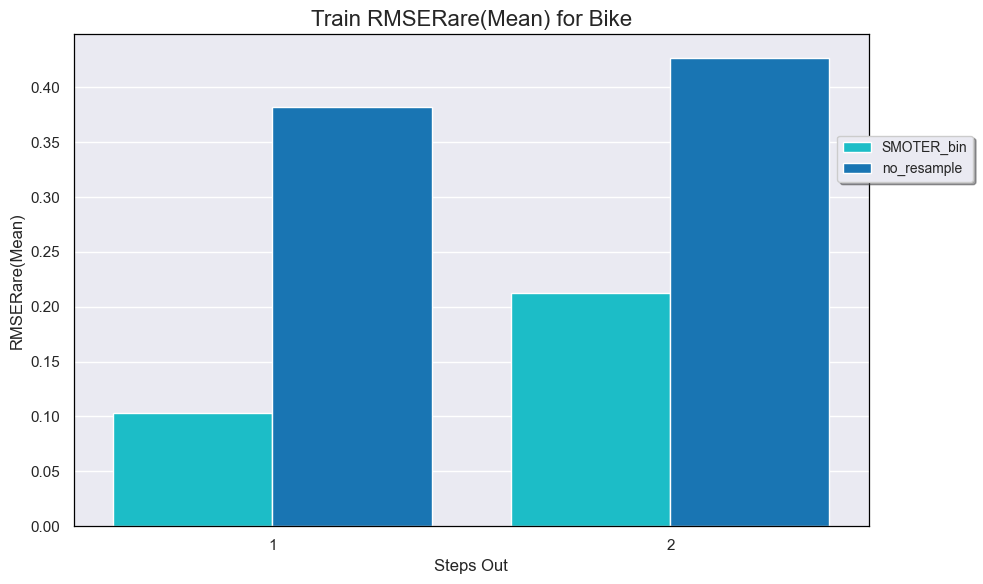

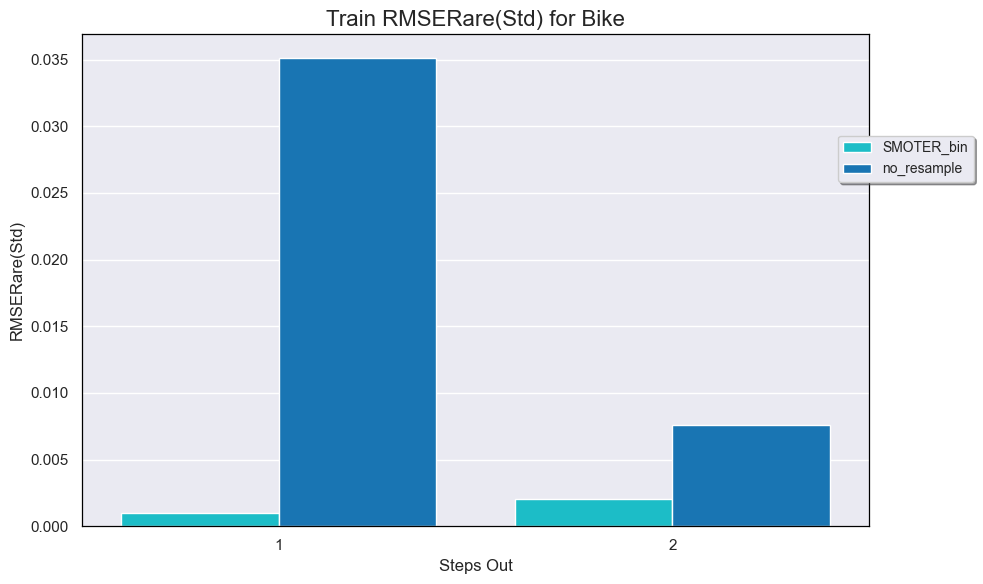

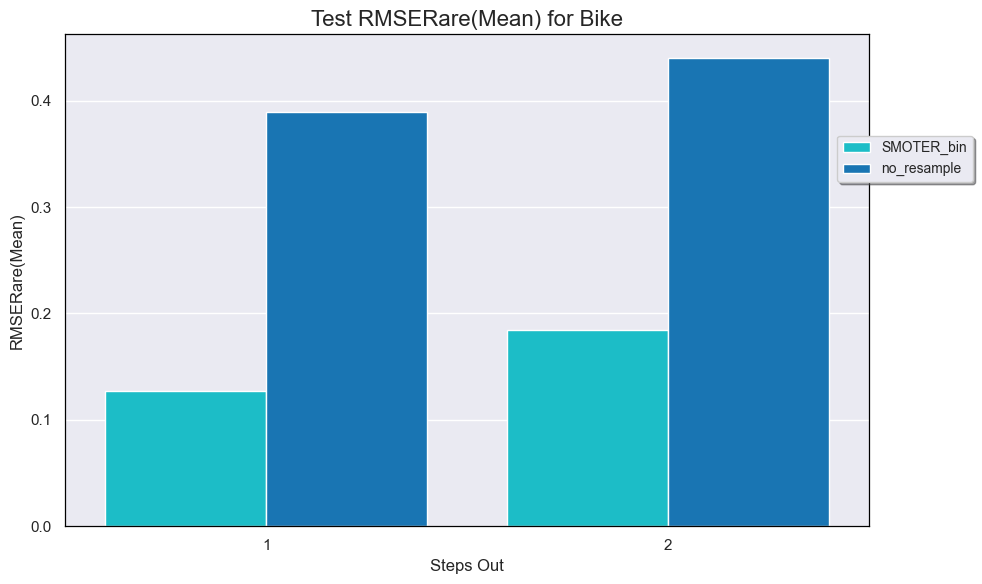

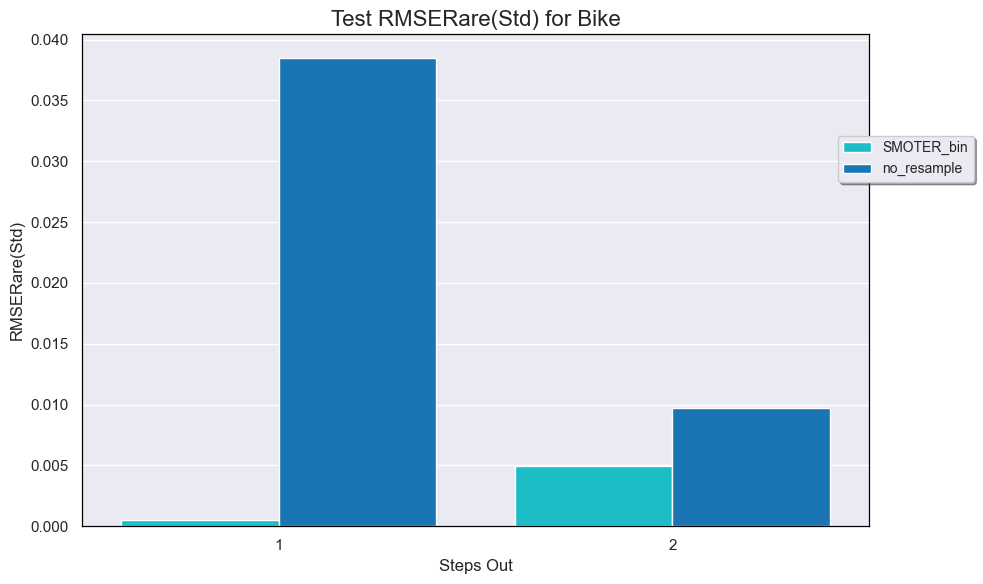

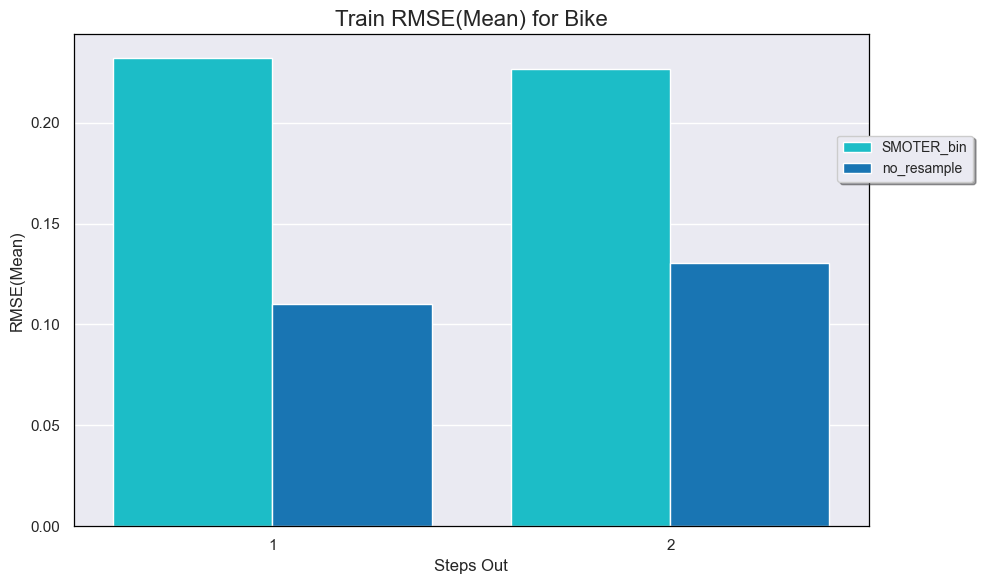

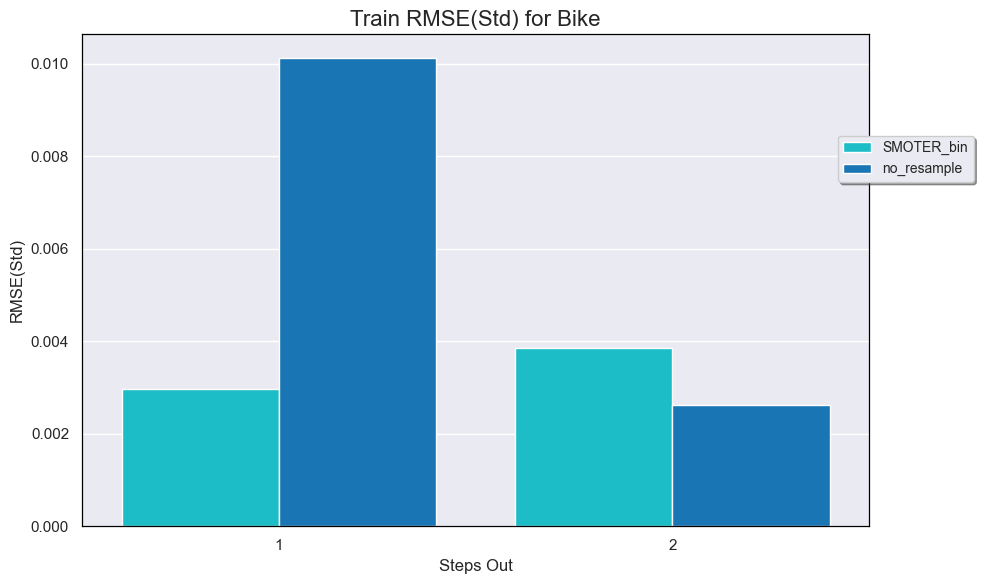

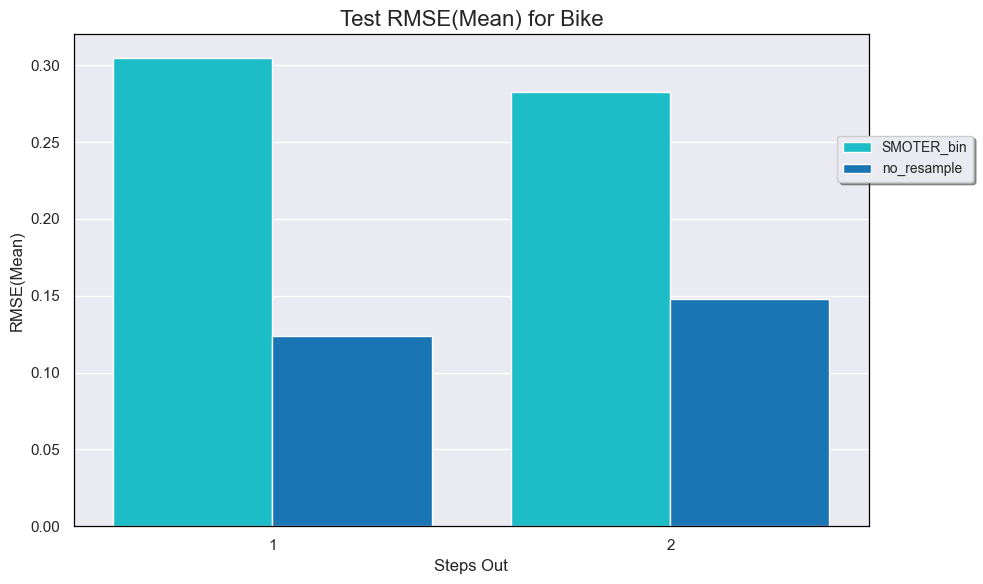

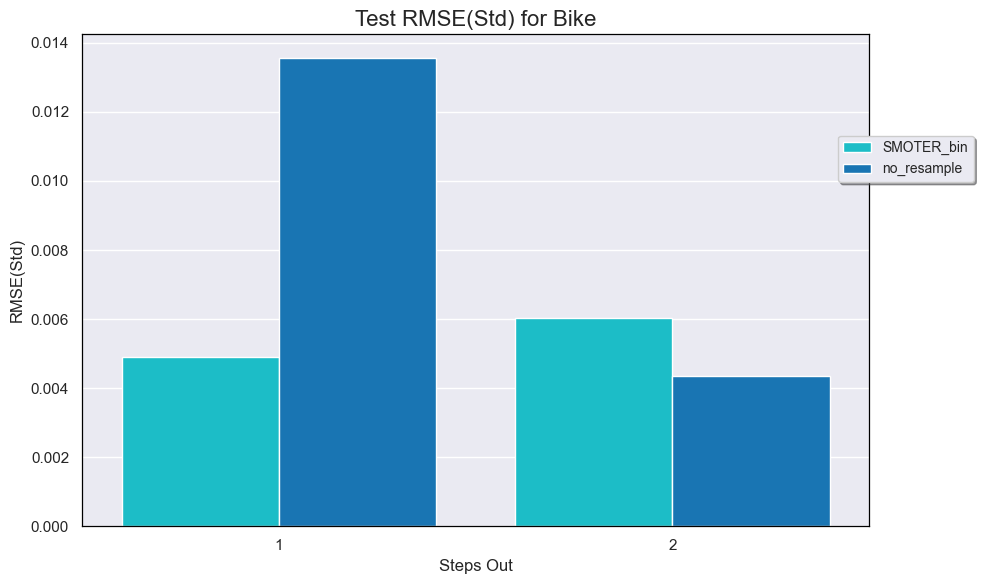

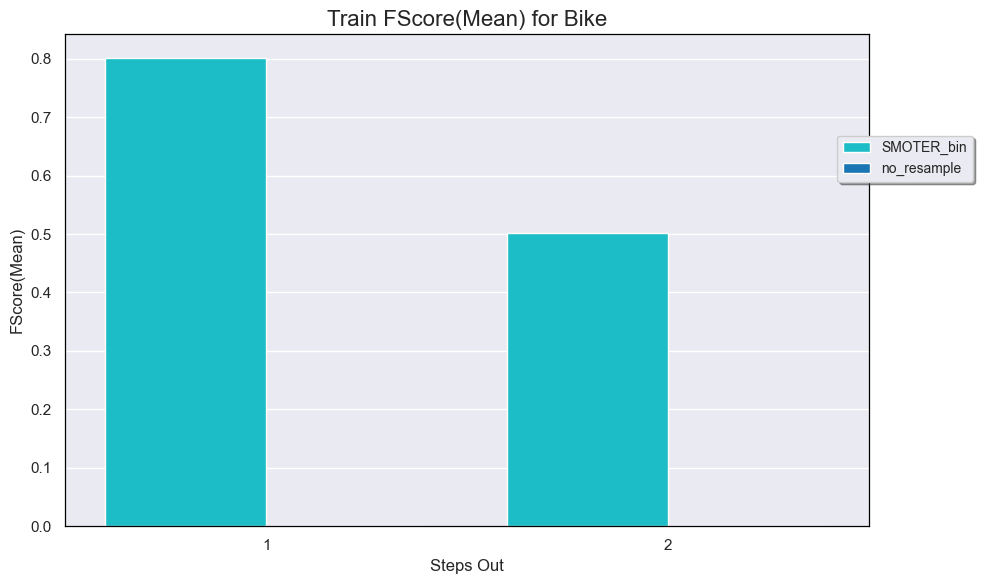

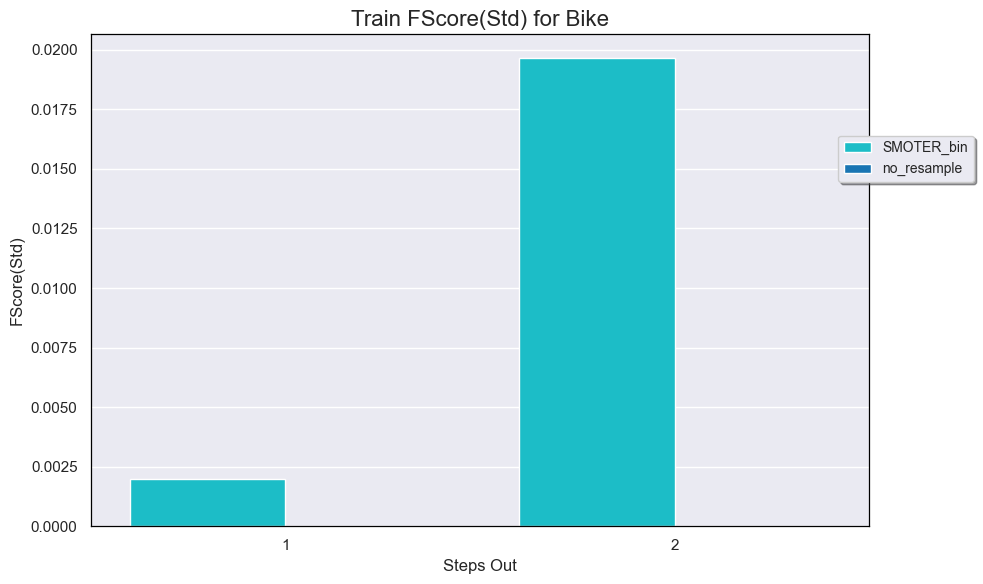

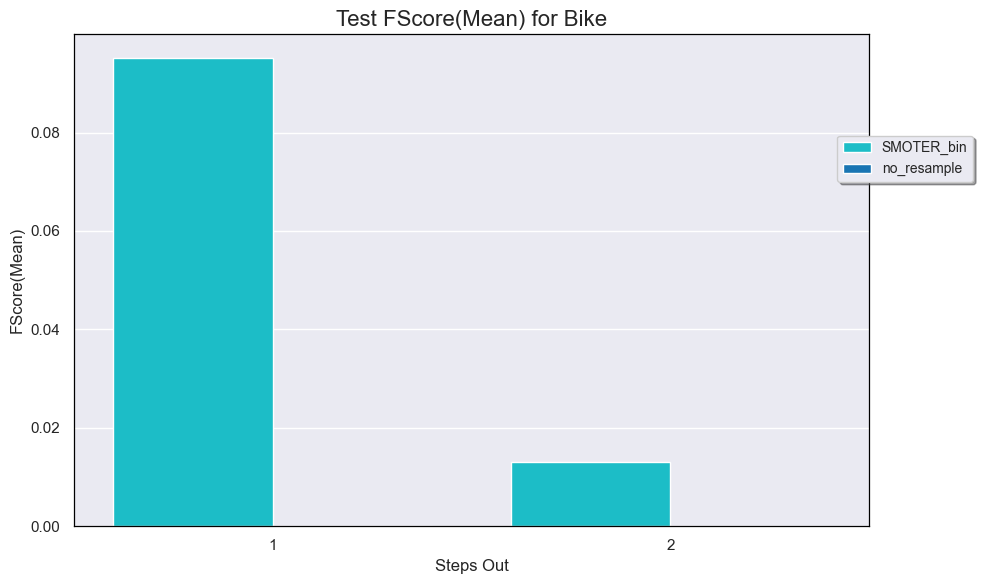

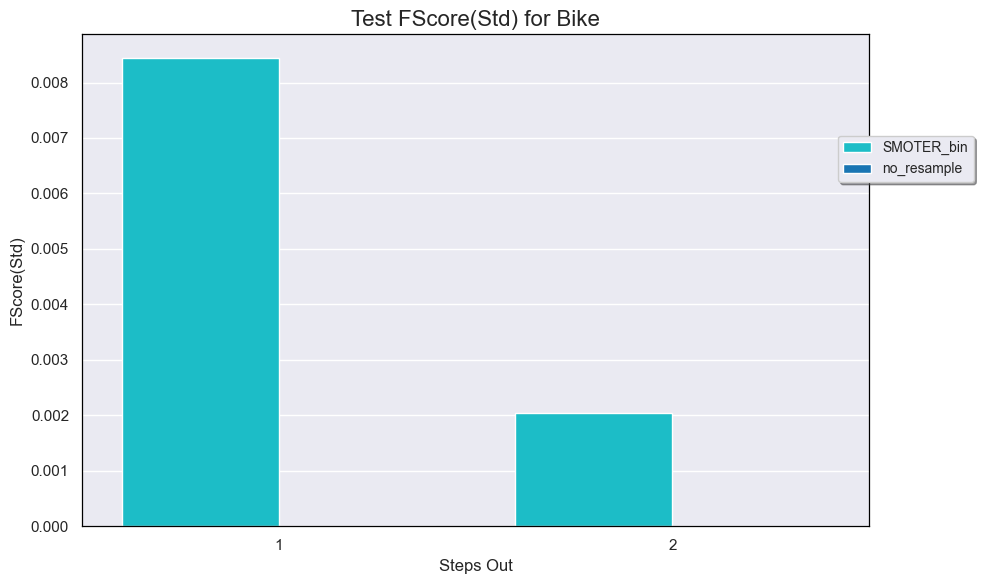

In [36]:
#Plot Mean/Std of Train/Test Metrics at each time step out
import plt_utils as pu
importlib.reload(pu)

plot_metrics = ["CaseWeight", "Utility", "RMSERare", "RMSE", "FScore"]
ts = ["Train", "Test"]
aggs = ["Mean", "Std"]

for metric in plot_metrics:
    for t in ts:
        tb = True if t == "Test" else False
        df_results = EVALER.getExperimentSummaryDf(metric, tb)
        for a in aggs:
            #filter out all GANs that aren't the best
            filtered_df = df_results[((df_results['Res'].str.contains('GAN_CNN|GAN_FNN')) & ((df_results['Res'] == best_cnn_gan) | (df_results['Res'] == best_fnn_gan))) | (~df_results['Res'].str.contains('GAN_CNN|GAN_FNN'))]
            filtered_df = filtered_df[((filtered_df['Res'].str.contains('SMOTER_bin')) & (filtered_df['Res'] == best_bin)) | (~filtered_df['Res'].str.contains('SMOTER_bin'))]
            pu.PlotStepBarResults(filtered_df, metric, a, t, DATA_NAME, N_STEPS_OUT)

**End of official code, everything under this is bunch of crap for testing**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

strat_cols = {
    'no_resample' : '#007ACC', #(Blue)
    'SMOTER_bin' : '#DC143C', #(Red)
    'GAN_CNN' : '#92D400', #(Green)
    'GAN_FNN' : '#FFC500', #(Yellow)
    'SMOTER_regular' : '#FF6F61', #(Orange)
    'SMOTER_bin_t' : '#A200FF', #(Purple)
    'SMOTER_bin_r' : '#00D6E3', #(Cyan)
    'SMOTER_bin_tr' : '#FF00A6', #(Magenta)
    'relevance' : '#8D93AB', #(Grey)
}

df = cw_results
met_v = f"{met}_{t}_{ag}"
# Create a new DataFrame with one row per 'Step' and one column per 'Res'
step_dfs = []
for i, row in df.iterrows():
    for j, met_value in enumerate(row[met_v]):
        step_df = pd.DataFrame({'Res': [row['Res']],
                                'Step': [f"{j+1}"],
                                met_v: [met_value]})
        step_dfs.append(step_df)

# Concatenate the step DataFrames into one
df_melted = pd.concat(step_dfs, ignore_index=True)

# Create the clustered bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Step', y=met_v, hue='Res', palette=strat_cols)
plt.xlabel('Steps Out', fontsize=12)
plt.ylabel(f"{met} ({ag})", fontsize=12)
plt.title(f"{t} {met} for {DATA_NAME} accross {N_STEPS_OUT} prediction horizons", fontsize=16)
plt.legend(fontsize=10, loc='upper right', shadow=True)
plt.show()

In [ ]:
import seaborn as sns
metvar = f"{met}_Test_Mean"
df_melted = cw_results.explode(metvar)
df_melted['Step'] = df_melted.groupby('Res').cumcount()
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Res', hue='Step', y=metvar)

plt.xlabel('Res')
plt.ylabel(met)
plt.title('Clustered Bar Plot of CW Values by Res and Step')
plt.legend(title='Step', loc='upper right', labels=[f'Step {i}' for i in range(3)])

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame
data = {'Res': ['A', 'B', 'C', 'D'],
        'CW_Train': [10.2, 15.3, 20.1, 12.5],
        'CW_Test': [8.5, 14.2, 18.7, 11.8]}

df = pd.DataFrame(data)

# Melt the DataFrame to create long-form data suitable for plotting
df_melted = pd.melt(df, id_vars=['Res'], value_vars=['CW_Train', 'CW_Test'], 
                    var_name='Type', value_name='Value')

# Create the clustered bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Type', y='Value', hue='Res', ci=None)
plt.xlabel('Type (CW_Train or CW_Test)')
plt.ylabel('Value')
plt.title('Clustered Barplot of CW_Train and CW_Test by Res')
plt.legend(title='Res', title_fontsize='15')
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample DataFrame
data = {'Res': ['A', 'B', 'C'],
        'CW': [[10, 20, 30], [15, 25, 35], [12, 22, 32]]}

df = pd.DataFrame(data)

# Create a new DataFrame with one row per 'Step' and one column per 'Res'
step_dfs = []
for i, row in df.iterrows():
    for j, cw_value in enumerate(row['CW']):
        step_df = pd.DataFrame({'Res': [row['Res']],
                                'Step': [f"Step {j}"],
                                'CW': [cw_value]})
        step_dfs.append(step_df)

# Concatenate the step DataFrames into one
df_melted = pd.concat(step_dfs, ignore_index=True)

# Create the clustered bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Step', y='CW', hue='Res')
plt.xlabel('Step')
plt.ylabel('CW Value')
plt.title('Clustered Bar Plot by Step')
plt.legend(title='Res')
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample DataFrame
data = {'Res': ['A', 'B', 'C'],
        'CW': [[10, 20, 30], [15, 25, 35], [12, 22, 32]]}
df = pd.DataFrame(data)
print(df)
# Create a new DataFrame to hold the exploded 'CW' values
df_melted = df.explode('CW')

# Extract the step number from the 'CW' column
df_melted['Step'] = df_melted.groupby('Res').cumcount()

# Create the clustered bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Res', hue='Step', y='CW')

plt.xlabel('Res')
plt.ylabel('CW Value')
plt.title('Clustered Bar Plot of CW Values by Res and Step')
plt.legend(title='Step', loc='upper right', labels=[f'Step {i}' for i in range(3)])

plt.show()


In [ ]:
#print(EVALER.getExperimentsSummaryTable(metric="RMSE"))
x = EVALER.getMetricScore(2,"bin_resample","RelevanceROC")
xreg = EVALER.getMetricScore(2,"regular_resample","RelevanceROC")
xorg = EVALER.getMetricScore(2,"Original data","RelevanceROC")
bin_fpr, bin_tpr, _ = x[2]
reg_fpr, reg_tpr, _ = xreg[2]
org_fpr, org_tpr, _ = xorg[2]
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(bin_fpr, bin_tpr, marker='.')
ax.plot(reg_fpr, reg_tpr, marker='.')
ax.plot(org_fpr, org_tpr, marker='.')
plt.legend(['bin', 'reg', 'org'])
plt.show()
#EVALER.getMetricScore(3,"Original data","RelevanceROC")
#EVALER.getMetricScore(3,"regular_resample","RelevanceROC")


In [ ]:
res_df = EVALER.results_df
#print(res_df)
x =res_df[res_df['Res'] == "Original data"]["RMSERare"+ "_Train"][:3].to_numpy().std()
print(x)
#print(np.std(x,axis=0))
#EVALER.results_df[EVALER.results_df['Res'] == 'bin_resample']['Exp'].max()

In [ ]:
res = resampling_results['bin_resample']
X_res = res[:,:(N_STEPS_IN*N_FVARS)]
X_res = X_res.reshape((X_res.shape[0],N_STEPS_IN,N_FVARS))
Y_res = res[:,(N_STEPS_IN*N_FVARS):]

print(f"X_res:{X_res.shape}")

train_params = {
        'num_exp': 1, 
        'n_steps_in': N_STEPS_IN,
        'n_steps_out': 1,
        'epochs': 100,
        'hidden': 10
    }

Num_Exp = train_params['num_exp']
n_steps_out = train_params['n_steps_out']
n_steps_in = train_params['n_steps_in']
hidden = train_params['hidden']
n_features = 1
Epochs = train_params['epochs']

model = Sequential()
model.add(LSTM(hidden, activation='relu', input_shape=(N_STEPS_IN,N_FVARS)))
model.add(Dense(N_STEPS_OUT))
model.compile(optimizer='adam', loss='mse')
model.summary()
print("Experiment in progress")

model.fit(X_res, Y_res, epochs=Epochs,batch_size=64, verbose=0, shuffle=False)
y_predicttrain = model.predict(X_res)
y_predicttest = model.predict(X_test)
print("Experiment complete")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, mean_squared_error


class Evaluator():
    eval_metrics = []
    
    def __init__(self, eval_params, rel_thresh, rel_func):
        for metric in EvaluationMetric.__subclasses__():
            m_name = metric.__name__
            if m_name not in eval_params.keys(): print(f"{m_name} out");continue
            print(f"{m_name} in")
            self.eval_metrics.append(metric(eval_params[m_name], rel_func, rel_thresh))
        self.results_df = self.initResultsDf()
    
    def initResultsDf(self):
        cols = []
        for metric in self.eval_metrics:
            cols = cols + metric.m_names
        cols = [item + suffix for suffix in ['_Train','_Test'] for item in cols]
        cols = ["Exp"]+cols
        return pd.DataFrame(columns=cols) 
            
    def evaluateMetrics(self, exp, train_pred, train_actual, test_pred, test_actual):
        exp_row = {"Exp": exp}
        for metric in self.eval_metrics:
            tr = metric.evaluate(train_pred, train_actual)
            tr = {key + "_Train": value for key, value in tr.items()}
            ts = metric.evaluate(test_pred, test_actual)
            ts = {key + "_Test": value for key, value in ts.items()}
            exp_row = {**exp_row, **tr, **ts}
        self.results_df = self.results_df.reset_index(drop=True)
        self.results_df = pd.concat([self.results_df, pd.DataFrame([exp_row])], ignore_index=True)
    
    def getMetricScore(self, exp, metric, test=True):
        df_col = metric + "_Test" if test else "_Train"
        return self.results_df.loc[self.results_df['Exp'] == exp][df_col].values[0]
    
    def getExperimentsSummaryTable(self):
        strat_meta = [['Metric','Train_Mean','Test_Mean','Train_Std','Test_Std']]
        #strat_meta = [['Metric','Train_Mean']]
        for metric in self.eval_metrics:
            for mname in metric.m_names:
                #Means for mname accross experiments
                tr_m = self.results_df[mname + "_Train"].mean()
                te_m = self.results_df[mname + "_Test"].mean()
                if self.results_df['Exp'].max() >= 2:
                    tr_std = self.results_df[mname + "_Train"].std()
                    te_std = self.results_df[mname + "_Test"].std()
                else:
                    tr_std = np.zeros_like(self.results_df[mname + "_Train"][0])
                    te_std = np.zeros_like(self.results_df[mname + "_Train"][0])
                tab_row = [mname, str(tr_m), str(te_m), str(tr_std), str(te_std)]
            strat_meta.append(tab_row)
        return tabulate(strat_meta,headers='firstrow',tablefmt='grid')

def absDeviationLoss(pred, actual):
    return np.abs(pred - actual)

def biVariateAutoRelevance(prel, arel, m):
    return np.add((1-m)*prel, m*arel)

class EvaluationMetric:
    def __init__(self):
        pass
    
    def evaluate(self):
        pass

class RMSE(EvaluationMetric):
    m_names = ["RMSE"]
    def __init__(self,params,rel_func,rel_thresh):
        pass

    def evaluate(self, pred, actual):
        print(f"RMSE actual: {actual.shape}")
        print(f"RMSE pred: {pred.shape}")
        return { "RMSE" : mean_squared_error(actual, pred,multioutput='raw_values')}
        
    
class RMSERare(EvaluationMetric):
    m_names = ["RMSERare"]
    def __init__(self, params,rel_func,rel_thresh):
        self.rel_func = rel_func
        self.rel_thresh = rel_thresh
        pass

    def evaluate(self, pred, actual):
        actual_rel = self.rel_func.__call__(actual, combine='first')
        rare_ind = np.argwhere(actual_rel >= self.rel_thresh).flatten()
        print(f"rare_ind: {rare_ind.shape}")
        print(f"actual after filtering out commons: {actual[rare_ind,:].shape}")
        print(f"pred after filtering out commons: {pred[rare_ind,:].shape}")
        rmse_rare = mean_squared_error(actual[rare_ind], pred[rare_ind], multioutput='raw_values')
        return {"RMSERare": rmse_rare}

#ToDo: this isn't implemented correctly
class Utility(EvaluationMetric):
    m_names = ["Utility","Benefit","Cost"]
    def __init__(self,params,rel_func,rel_thresh):
        self.rel_func = rel_func
        self.rel_thresh = rel_thresh
        self.bmax = params['B_max']
        self.cmax = params['C_max']
        self.mbirel = params['m']
    
    def utilityBasedCost(self, pred, actual):
        pred_rel = self.rel_func.__call__(pred)
        actual_rel = self.rel_func.__call__(actual)
        return np.sum(self.cmax*np.multiply(biVariateAutoRelevance(pred_rel, actual_rel, self.mbirel),absDeviationLoss(pred_rel,actual_rel)))

    def utilityBasedBenefit(self, pred, actual):
        pred_rel = self.rel_func.__call__(pred)
        actual_rel = self.rel_func.__call__(actual)
        return np.sum(self.bmax*np.multiply(actual_rel, (1-absDeviationLoss(pred_rel, actual_rel))))

    def evaluate(self, pred, actual):
        benefit = self.utilityBasedBenefit(pred, actual)
        cost = self.utilityBasedCost(pred, actual)
        utility = benefit - cost
        return {"Utility": utility, "Benefit": benefit, "Cost": cost}

class CaseWeight(EvaluationMetric):
    m_names = ["CaseWeight"]
    def __init__(self,params,rel_func,rel_thresh):
        self.rel_func = rel_func
        self.rel_thresh = rel_thresh
        self.mbirel = params['m']
    
    def evaluate(self, pred, actual):
        #pred = np.reshape(pred,(-1,))
        pred_rel = self.rel_func.__call__(pred, combine='none')
        actual_rel = self.rel_func.__call__(actual, combine='none')
        biRel = biVariateAutoRelevance(pred_rel,actual_rel,self.mbirel)
        loss = (pred-actual)**2

        caseMult = np.multiply(biRel,loss)
        case_weight = np.sum(caseMult,axis=0) / np.sum(biRel,axis=0)
        return {"CaseWeight": case_weight}

class PrecisionRecall(EvaluationMetric):
    m_names = ["Precision", "Recall"]
    def __init__(self,params,rel_func,rel_thresh):
        self.rel_func = rel_func
        self.rel_thresh = rel_thresh
        
    def evaluate(self, pred, actual):
        ind_pred = self.rel_func.__call__(pred,combine='first')
        ind_actual = self.rel_func.__call__(actual,combine='first')
        ind_actual[ind_actual <= self.rel_thresh] = 0
        ind_actual[ind_actual > self.rel_thresh] = 1
        ind_pred[ind_pred <= self.rel_thresh] = 0
        ind_pred[ind_pred > self.rel_thresh] = 1
        precision = precision_score(ind_actual, ind_pred, average=None)
        recall = recall_score(ind_actual, ind_pred, average=None)
        return {"Precision": precision, "Recall": recall}

#ev = Evaluator(2,eval_params, relevance_function, RELEVANCE_THRESH)
#for ex in range(2):
#    ev.evaluateMetrics(ex,1,2,3,4)
#print(ev.results_df)

In [ ]:
#Useful for when we bring the evaluator into the notebook for debug, since re-importing the module is not possible unless we restart kernel
evaluator_params = { "RMSE": {},
                     "RMSERare": {},
                     #"Utility": {'B_max':0.2, 'C_max':0.1, 'm':0.5},
                     "CaseWeight": {'m':0.5},
                     #"PrecisionRecall": {}
                   }

EVALER = Evaluator(evaluator_params, RELEVANCE_THRESHOLD, RELEVANCE_FUNCTION)
#EVALER.evaluateMetrics(1,y_predicttrain[:,0],Y_res[:,0],y_predicttest[:,0],Y_test[:,0])
EVALER.evaluateMetrics(1,y_predicttrain,Y_res,y_predicttest,Y_test)
rmse_metric = EVALER.getMetricScore(1, 'RMSE', test=True)
print(f"rmse: {rmse_metric}")
rmserare_metric = EVALER.getMetricScore(1, 'RMSERare', test=True)
print(f"rmseRare: {rmserare_metric}")
cw_metric = EVALER.getMetricScore(1, 'CaseWeight', test=True)
print(f"CaseWeight: {cw_metric}")
#pr_metric = EVALER.getMetricScore(1, 'Precision', test=True)
#print(f"Precision: {pr_metric}")
#r_metric = EVALER.getMetricScore(1, 'Recall', test=True)
#print(f"Recall: {r_metric}")

print(EVALER.results_df)
print(EVALER.getExperimentsSummaryTable())

In [ ]:
main(N_STEPS_IN, X_train, X_test, Y_train, Y_test, resampling_results, EVALER)

Sunspot relevance threshold = 0.6

In [ ]:
relevance_threshold = 0.6
RELEVANCE_THRESH, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_QUANT, r_y, k_y, relevance_function = calculate_relevance(y_train, relevance_threshold)

In [ ]:
resampling_results = run_resampling(k_x, k_y, r_y, time_step,relevance_function, relevance_threshold)

In [ ]:
plot_relevance_bins(k_x, k_y, time_step)

In [ ]:
plot_resampled_data(resampling_results, time_step)

In [ ]:
main(time_step, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_THRESH, RELEVANCE_QUANT, X_train, X_test, y_train, y_test, resampling_results)

Sunspots relevance_threshold = 0.8

In [ ]:
relevance_threshold = 0.8
RELEVANCE_THRESH, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_QUANT, r_y, k_y, relevance_function = calculate_relevance(y_train, relevance_threshold)

In [ ]:
resampling_results = run_resampling(k_x, k_y, r_y, time_step,relevance_function, relevance_threshold)

In [ ]:
plot_relevance_bins(k_x, k_y, time_step)

In [ ]:
plot_resampled_data(resampling_results, time_step)

In [ ]:
main(time_step, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_THRESH, RELEVANCE_QUANT, X_train, X_test, y_train, y_test, resampling_results)

In [ ]:
relevance_threshold = 1
RELEVANCE_THRESH, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_QUANT, r_y, k_y, relevance_function = calculate_relevance(y_train, relevance_threshold)

In [ ]:
resampling_results = run_resampling(k_x, k_y, r_y, time_step,relevance_function, relevance_threshold)

In [ ]:
plot_relevance_bins(k_x, k_y, time_step)

In [ ]:
plot_resampled_data(resampling_results, time_step)

In [ ]:
main(time_step, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_THRESH, RELEVANCE_QUANT, X_train, X_test, y_train, y_test, resampling_results)

**Haven't altered/used any code past this point**



**Data**

**Mackey-Glass**

In [ ]:
df=pd.read_csv("./data/mackey.dat.txt", header=None)

In [ ]:
df.head()

In [ ]:
df.tail()
df = df.reset_index()[0]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
print(df)
df=scaler.fit_transform(np.array(df).reshape(-1,1)) 
print(df)
#makes target values between 0 and 1
#and puts them in numpy format [[y_t], [y_t+1], [y_t+2], ...]

In [ ]:
plot_data(df)

In [ ]:
k_x, X_train, y_train, X_test, y_test = split_data(df)
k_x

In [ ]:
relevance_threshold = 0.4
RELEVANCE_THRESH, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_QUANT, r_y, k_y, relevance_function = calculate_relevance(y_train, relevance_threshold)

In [ ]:
plot_relevance_bins(k_x, k_y, time_step)

In [ ]:
resampling_results = run_resampling(k_x, k_y, r_y, time_step, relevance_function, relevance_threshold)

In [ ]:
plot_resampled_data(resampling_results, time_step)

In [ ]:
main(time_step, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_THRESH, RELEVANCE_QUANT, X_train, X_test, y_train, y_test, resampling_results)

relevance_threshold = 0.6

In [ ]:
relevance_threshold = 0.6
RELEVANCE_THRESH, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_QUANT, r_y, k_y, relevance_function = calculate_relevance(y_train, relevance_threshold)

In [ ]:
resampling_results = run_resampling(k_x, k_y, r_y, time_step,relevance_function, relevance_threshold)

In [ ]:
plot_relevance_bins(k_x, k_y, time_step)

In [ ]:
plot_resampled_data(resampling_results, time_step)

In [ ]:
main(time_step, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_THRESH, RELEVANCE_QUANT, X_train, X_test, y_train, y_test, resampling_results)

relevance_threshold = 0.8

In [ ]:
relevance_threshold = 0.8
RELEVANCE_THRESH, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_QUANT, r_y, k_y, relevance_function = calculate_relevance(y_train, relevance_threshold)

In [ ]:
resampling_results = run_resampling(k_x, k_y, r_y, time_step,relevance_function, relevance_threshold)

In [ ]:
plot_relevance_bins(k_x, k_y, time_step)

In [ ]:
plot_resampled_data(resampling_results, time_step)

In [ ]:
main(time_step, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_THRESH, RELEVANCE_QUANT, X_train, X_test, y_train, y_test, resampling_results)

**Lorenz**

In [ ]:
df=pd.read_csv("./data/lorenz.dat.txt", header=None)

In [ ]:
df.head()

In [ ]:
df.tail()
df = df.reset_index()[0]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
print(df)
df=scaler.fit_transform(np.array(df).reshape(-1,1)) 
print(df)
#makes target values between 0 and 1
#and puts them in numpy format [[y_t], [y_t+1], [y_t+2], ...]

In [ ]:
plot_data(df)

In [ ]:
k_x, X_train, y_train, X_test, y_test = split_data(df)
k_x

In [ ]:
relevance_threshold = 0.4
RELEVANCE_THRESH, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_QUANT, r_y, k_y, relevance_function = calculate_relevance(y_train, relevance_threshold)

In [ ]:
plot_relevance_bins(k_x, k_y, time_step)

In [ ]:
resampling_results = run_resampling(k_x, k_y, r_y, time_step, relevance_function, relevance_threshold)

In [ ]:
plot_resampled_data(resampling_results, time_step)

In [ ]:
main(time_step, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_THRESH, RELEVANCE_QUANT, X_train, X_test, y_train, y_test, resampling_results)

relevance_threshold = 0.6

In [ ]:
relevance_threshold = 0.6
RELEVANCE_THRESH, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_QUANT, r_y, k_y, relevance_function = calculate_relevance(y_train, relevance_threshold)

In [ ]:
resampling_results = run_resampling(k_x, k_y, r_y, time_step,relevance_function, relevance_threshold)

In [ ]:
plot_relevance_bins(k_x, k_y, time_step)

In [ ]:
plot_resampled_data(resampling_results, time_step)

In [ ]:
main(time_step, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_THRESH, RELEVANCE_QUANT, X_train, X_test, y_train, y_test, resampling_results)

relevance_threshold = 0.8

In [ ]:
relevance_threshold = 0.8
RELEVANCE_THRESH, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_QUANT, r_y, k_y, relevance_function = calculate_relevance(y_train, relevance_threshold)

In [ ]:
resampling_results = run_resampling(k_x, k_y, r_y, time_step,relevance_function, relevance_threshold)

In [ ]:
plot_relevance_bins(k_x, k_y, time_step)

In [ ]:
plot_resampled_data(resampling_results, time_step)

In [ ]:
main(time_step, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_THRESH, RELEVANCE_QUANT, X_train, X_test, y_train, y_test, resampling_results)

**Henon**

In [ ]:
df=pd.read_csv("./data/henon.dat.txt", header=None)

In [ ]:
df.head()

In [ ]:
df.tail()
df = df.reset_index()[0]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
print(df)
df=scaler.fit_transform(np.array(df).reshape(-1,1)) 
print(df)
#makes target values between 0 and 1
#and puts them in numpy format [[y_t], [y_t+1], [y_t+2], ...]

In [ ]:
plot_data(df)

In [ ]:
k_x, X_train, y_train, X_test, y_test = split_data(df)
k_x

In [ ]:
relevance_threshold = 0.4
RELEVANCE_THRESH, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_QUANT, r_y, k_y, relevance_function = calculate_relevance(y_train, relevance_threshold)

In [ ]:
plot_relevance_bins(k_x, k_y, time_step)

In [ ]:
resampling_results = run_resampling(k_x, k_y, r_y, time_step, relevance_function, relevance_threshold)

In [ ]:
plot_resampled_data(resampling_results, time_step)

In [ ]:
main(time_step, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_THRESH, RELEVANCE_QUANT, X_train, X_test, y_train, y_test, resampling_results)

relevance_threshold = 0.6

In [ ]:
relevance_threshold = 0.6
RELEVANCE_THRESH, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_QUANT, r_y, k_y, relevance_function = calculate_relevance(y_train, relevance_threshold)

In [ ]:
resampling_results = run_resampling(k_x, k_y, r_y, time_step,relevance_function, relevance_threshold)

In [ ]:
plot_relevance_bins(k_x, k_y, time_step)

In [ ]:
plot_resampled_data(resampling_results, time_step)

In [ ]:
main(time_step, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_THRESH, RELEVANCE_QUANT, X_train, X_test, y_train, y_test, resampling_results)

relevance_threshold = 0.8

In [ ]:
relevance_threshold = 0.8
RELEVANCE_THRESH, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_QUANT, r_y, k_y, relevance_function = calculate_relevance(y_train, relevance_threshold)

In [ ]:
resampling_results = run_resampling(k_x, k_y, r_y, time_step,relevance_function, relevance_threshold)

In [ ]:
plot_relevance_bins(k_x, k_y, time_step)

In [ ]:
plot_resampled_data(resampling_results, time_step)

In [ ]:
main(time_step, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_THRESH, RELEVANCE_QUANT, X_train, X_test, y_train, y_test, resampling_results)

**ACFinance**

In [ ]:
df=pd.read_csv("./data/acfinance.txt", header=None)

In [ ]:
df.head()

In [ ]:
df.tail()
df = df.reset_index()[0]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
print(df)
df=scaler.fit_transform(np.array(df).reshape(-1,1)) 
print(df)
#makes target values between 0 and 1
#and puts them in numpy format [[y_t], [y_t+1], [y_t+2], ...]

In [ ]:
plot_data(df)

In [ ]:
k_x, X_train, y_train, X_test, y_test = split_data(df)
k_x

In [ ]:
relevance_threshold = 0.4
RELEVANCE_THRESH, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_QUANT, r_y, k_y, relevance_function = calculate_relevance(y_train, relevance_threshold)

In [ ]:
plot_relevance_bins(k_x, k_y, time_step)

In [ ]:
resampling_results = run_resampling(k_x, k_y, r_y, time_step, relevance_function, relevance_threshold)

In [ ]:
plot_resampled_data(resampling_results, time_step)

In [ ]:
main(time_step, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_THRESH, RELEVANCE_QUANT, X_train, X_test, y_train, y_test, resampling_results)

relevance_threshold = 0.6

In [ ]:
relevance_threshold = 0.6
RELEVANCE_THRESH, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_QUANT, r_y, k_y, relevance_function = calculate_relevance(y_train, relevance_threshold)

In [ ]:
resampling_results = run_resampling(k_x, k_y, r_y, time_step,relevance_function, relevance_threshold)

In [ ]:
plot_relevance_bins(k_x, k_y, time_step)

In [ ]:
plot_resampled_data(resampling_results, time_step)

In [ ]:
main(time_step, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_THRESH, RELEVANCE_QUANT, X_train, X_test, y_train, y_test, resampling_results)

relevance_threshold = 0.8

In [ ]:
relevance_threshold = 0.8
RELEVANCE_THRESH, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_QUANT, r_y, k_y, relevance_function = calculate_relevance(y_train, relevance_threshold)

In [ ]:
resampling_results = run_resampling(k_x, k_y, r_y, time_step,relevance_function, relevance_threshold)

In [ ]:
plot_relevance_bins(k_x, k_y, time_step)

In [ ]:
plot_resampled_data(resampling_results, time_step)

In [ ]:
main(time_step, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_THRESH, RELEVANCE_QUANT, X_train, X_test, y_train, y_test, resampling_results)

**Rossler**

In [ ]:
df=pd.read_csv("./data/rossler.dat.txt", header=None)

In [ ]:
df.head()

In [ ]:
df.tail()
df = df.reset_index()[0]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
print(df)
df=scaler.fit_transform(np.array(df).reshape(-1,1)) 
print(df)
#makes target values between 0 and 1
#and puts them in numpy format [[y_t], [y_t+1], [y_t+2], ...]

In [ ]:
plot_data(df)

In [ ]:
k_x, X_train, y_train, X_test, y_test = split_data(df)
k_x

In [ ]:
relevance_threshold = 0.4
RELEVANCE_THRESH, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_QUANT, r_y, k_y, relevance_function = calculate_relevance(y_train, relevance_threshold)

In [ ]:
plot_relevance_bins(k_x, k_y, time_step)

In [ ]:
resampling_results = run_resampling(k_x, k_y, r_y, time_step, relevance_function, relevance_threshold)

In [ ]:
plot_resampled_data(resampling_results, time_step)

In [ ]:
main(time_step, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_THRESH, RELEVANCE_QUANT, X_train, X_test, y_train, y_test, resampling_results)

relevance_threshold = 0.6

In [ ]:
relevance_threshold = 0.6
RELEVANCE_THRESH, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_QUANT, r_y, k_y, relevance_function = calculate_relevance(y_train, relevance_threshold)

In [ ]:
#resampling_results = run_resampling(k_x, k_y, r_y, time_step,relevance_function, relevance_threshold)
res_strats = ["regular_resample", "bin_resample"]#, "bin_temp_resample", "bin_rel_resample", "bin_tempRel_resample"]
resampling_results = run_resampling(k_x, k_y, r_y, res_strats, time_step, relevance_function, relevance_threshold)

In [ ]:
plot_relevance_bins(k_x, k_y, time_step)

In [ ]:
plot_resampled_data(resampling_results, time_step)

In [ ]:
main(time_step, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_THRESH, RELEVANCE_QUANT, X_train, X_test, y_train, y_test, resampling_results)

relevance_threshold = 0.8

In [ ]:
relevance_threshold = 0.8
RELEVANCE_THRESH, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_QUANT, r_y, k_y, relevance_function = calculate_relevance(y_train, relevance_threshold)

In [ ]:
resampling_results = run_resampling(k_x, k_y, r_y, time_step,relevance_function, relevance_threshold)

In [ ]:
plot_relevance_bins(k_x, k_y, time_step)

In [ ]:
plot_resampled_data(resampling_results, time_step)

In [ ]:
main(time_step, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_THRESH, RELEVANCE_QUANT, X_train, X_test, y_train, y_test, resampling_results)

**Lazer**

In [ ]:
df=pd.read_csv("./data/lazer.csv")

In [ ]:
df.head()

In [ ]:
df.tail()
df = df.reset_index()[0]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
print(df)
df=scaler.fit_transform(np.array(df).reshape(-1,1)) 
print(df)
#makes target values between 0 and 1
#and puts them in numpy format [[y_t], [y_t+1], [y_t+2], ...]

In [ ]:
plot_data(df)

In [ ]:
k_x, X_train, y_train, X_test, y_test = split_data(df)
k_x

In [ ]:
relevance_threshold = 0.4
RELEVANCE_THRESH, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_QUANT, r_y, k_y, relevance_function = calculate_relevance(y_train, relevance_threshold)

In [ ]:
plot_relevance_bins(k_x, k_y, time_step)

In [ ]:
resampling_results = run_resampling(k_x, k_y, r_y, time_step, relevance_function, relevance_threshold)

In [ ]:
plot_resampled_data(resampling_results, time_step)

In [ ]:
main(time_step, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_THRESH, RELEVANCE_QUANT, X_train, X_test, y_train, y_test, resampling_results)

relevance_threshold = 0.6

In [ ]:
relevance_threshold = 0.6
RELEVANCE_THRESH, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_QUANT, r_y, k_y, relevance_function = calculate_relevance(y_train, relevance_threshold)

In [ ]:
resampling_results = run_resampling(k_x, k_y, r_y, time_step,relevance_function, relevance_threshold)

In [ ]:
plot_relevance_bins(k_x, k_y, time_step)

In [ ]:
plot_resampled_data(resampling_results, time_step)

In [ ]:
main(time_step, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_THRESH, RELEVANCE_QUANT, X_train, X_test, y_train, y_test, resampling_results)

relevance_threshold = 0.8

In [ ]:
relevance_threshold = 0.8
RELEVANCE_THRESH, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_QUANT, r_y, k_y, relevance_function = calculate_relevance(y_train, relevance_threshold)

In [ ]:
resampling_results = run_resampling(k_x, k_y, r_y, time_step,relevance_function, relevance_threshold)

In [ ]:
plot_relevance_bins(k_x, k_y, time_step)

In [ ]:
plot_resampled_data(resampling_results, time_step)

In [ ]:
main(time_step, SAMPLE_MEAN, SAMPLE_STD, RELEVANCE_THRESH, RELEVANCE_QUANT, X_train, X_test, y_train, y_test, resampling_results)

**Evaluating the Result of the Combined LSTM**

In [ ]:
arr = test_acc
arr=arr.reshape(Num_Exp,1)
arr=np.concatenate((arr,Step_RMSE), axis=1)
arr=arr.reshape(Num_Exp,1+n_steps_out)
            
ExpIndex=np.array([])
for j in range(Num_Exp):
    ExpIndex=np.concatenate((ExpIndex,["Exp"+str(j+1)]))

ExpIndex1=['TestRMSE']
for j in range(n_steps_out):
    ExpIndex1=np.concatenate((ExpIndex1,["Step"+str(j+1)]))
                
arr=np.round_(arr, decimals = 5) 
arr = pd.DataFrame(arr, index = ExpIndex , columns = ExpIndex1)
print(arr)

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test, label='actual')
plt.plot(x_data, Best_Predict_Test, label='predicted')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
plt.show()
plt.close()